In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, lit, udf, greatest, mean as _mean, stddev as _stddev, max as spark_max, expm1, row_number
import numpy as np
import pandas as pd
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
spark = SparkSession.builder \
    .appName("OfflineModelCV") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

parquet_path = "hdfs://namenode:9000/user/hadoop/dane_przetworzone/meteo_gios_model_ready_log.parquet"
df = spark.read.parquet(parquet_path)

df.show(5)

pdf = df.toPandas()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 07:51:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/31 07:51:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------------------+-----------+--------+---------+----+--------+--------+-----------+----------+--------+----+------+-------+-------+---+----+-----------+-----+----+--------+--------+--------+--------+-------+-------+------+------+-------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       datetime_utc|temperature|humidity|dew_point|rain|snowfall|pressure|cloud_cover|wind_speed|wind_dir| no2|    o3|   pm10|   pm25|so2|hour|day_of_week|month|year|pm10_t-1|pm10_t+1|pm25_t-1|pm25_t+1|no2_t-1|no2_t+1|o3_t-1|o3_t+1|so2_t-1|so2_t+1|           log_no2|            log_o3|          log_pm10|          log_pm25|           log_so2|      log_pm10_t-1|      log_pm10_t+1|      log_pm25_t-1|      log_pm25_t+1|       log_no2_t-1|       log_no2_t+1|       

In [ ]:
def timeseries_cv_rf(
    df_to_cv,
    datetime_col,
    feature_cols,
    target_col,
    param_grid,
    folds=3,
    seed=42,
    is_log=False,
    model_save_path=None
):
    """
    Time series cross-validation dla RandomForest na danych Spark.

    df_to_cv - Spark DataFrame posortowany po datetime_col
    datetime_col - kolumna datetime, do sortowania
    feature_cols - lista kolumn cech
    target_col - nazwa kolumny celu (label)
    param_grid - dict z hiperparametrami, np. {"numTrees": [50,100], "maxDepth": [5,10]}
    folds - liczba foldów CV
    seed - seed do losowości (jeśli potrzebne)
    is_log - czy target jest w log1p (log(x+1)) - wtedy ewaluacja metryk na normalnej skali

    Zwraca (best_params, final_model)
    """

    df_sorted = df_to_cv.orderBy(datetime_col)
    total_count = df_sorted.count()
    train_count = int(total_count * 0.8)

    w_all = Window.partitionBy(lit(1)).orderBy(datetime_col)
    df_indexed = df_sorted.withColumn("row_num", row_number().over(w_all))
    
    train_val_data = df_indexed.filter(col("row_num") <= train_count).drop("row_num")
    
    test_data = df_indexed.filter(col("row_num") > train_count).drop("row_num")
    
    train_val_count = train_val_data.count()
    val_size = int(train_val_count * 0.25)

    w = Window.partitionBy(lit(1)).orderBy(datetime_col)
    train_val_indexed = train_val_data.withColumn("row_num", row_number().over(w))

    def slice_df(df_in, start_idx, end_idx):
        return df_in.filter((col("row_num") > start_idx) & (col("row_num") <= end_idx))

    folds = [
        # Fold 1
        {
            "train": slice_df(train_val_indexed, 0, val_size),
            "val": slice_df(train_val_indexed, val_size, val_size*2)
        },
        # Fold 2
        {
            "train": slice_df(train_val_indexed, 0, val_size*2),
            "val": slice_df(train_val_indexed, val_size*2, val_size*3)
        },
        # Fold 3
        {
            "train": slice_df(train_val_indexed, 0, val_size*3),
            "val": slice_df(train_val_indexed, val_size*3, val_size*4)
        }
    ]
    
    
    evaluator = RegressionEvaluator(labelCol="label_eval", predictionCol="prediction_eval", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="label_eval", predictionCol="prediction_eval", metricName="r2")


    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

    best_params = None
    best_rmse = float("inf")


    def prepare_eval_df(pred_df):
        if is_log:
            return pred_df.withColumn("prediction_eval", expm1(col("prediction"))) \
                          .withColumn("label_eval", expm1(col(target_col)))
        else:
            return pred_df.withColumn("prediction_eval", col("prediction")) \
                          .withColumn("label_eval", col(target_col))
    results = []
    
    for num_trees in param_grid.get("numTrees", [100]):
        for max_depth in param_grid.get("maxDepth", [5]):
            print(f"\nTestuję parametry: numTrees={num_trees}, maxDepth={max_depth}")
            rmses = []
            r2s = []

            for i, fold in enumerate(folds, 1):
                train_fold = fold["train"].drop("row_num")
                val_fold = fold["val"].drop("row_num")
                
                rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol=target_col,
                                           numTrees=num_trees, maxDepth=max_depth, seed=seed)

                pipeline = Pipeline(stages=[assembler, scaler, rf])
                model = pipeline.fit(train_fold)
                predictions = model.transform(val_fold)

                predictions_eval = prepare_eval_df(predictions)

                rmse = evaluator.evaluate(predictions_eval)
                r2 = evaluator_r2.evaluate(predictions_eval)
                rmses.append(rmse)
                r2s.append(r2)
            
                print(f" Fold {i}: RMSE={rmse:.4f}, R2={r2:.4f}")

            avg_rmse = sum(rmses) / len(folds)
            avg_r2 = sum(r2s) / len(folds)
            print(f" Średni RMSE dla parametrów numTrees={num_trees}, maxDepth={max_depth}: {avg_rmse:.4f}")
            print(f" Średni R2 dla parametrów numTrees={num_trees}, maxDepth={max_depth}: {avg_r2:.4f}")

            results.append({
                "numTrees": num_trees,
                "maxDepth": max_depth,
                "avg_rmse": avg_rmse,
                "avg_r2": avg_r2
            })

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = {"numTrees": num_trees, "maxDepth": max_depth}

    print(f"Najlepsze parametry: {best_params} z RMSE: {best_rmse}")

    rf_best = RandomForestRegressor(featuresCol="scaledFeatures", labelCol=target_col,
                                    numTrees=best_params["numTrees"], maxDepth=best_params["maxDepth"], seed=seed)
    pipeline_best = Pipeline(stages=[assembler, scaler, rf_best])
    final_model = pipeline_best.fit(train_val_data)

    if model_save_path:
        final_model.write().overwrite().save(model_save_path)
        print(f"Model zapisany na HDFS pod: {model_save_path}")
    
    predictions_test = final_model.transform(test_data)
    
    if is_log:
        predictions_test = predictions_test.withColumn("prediction_eval", expm1(col("prediction"))) \
                                           .withColumn("label_eval", expm1(col(target_col)))
    else:
        predictions_test = predictions_test.withColumn("prediction_eval", col("prediction")) \
                                           .withColumn("label_eval", col(target_col))
    
    rmse_test = evaluator.evaluate(predictions_test)
    r2_test = evaluator_r2.evaluate(predictions_test)
    
    print(f"Test set RMSE: {rmse_test:.4f}")
    print(f"Test set R2: {r2_test:.4f}")

    rf_model = final_model.stages[-1]
    importances = rf_model.featureImportances.toArray()
    feature_importances = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    })
    threshold = 0.00005
    
    df_main_imp = feature_importances[feature_importances["importance"] >= threshold].copy()
    df_other_imp = feature_importances[feature_importances["importance"] < threshold].copy()
    
    if not df_other_imp.empty:
        other_row = pd.DataFrame([{
            "feature": "other",
            "importance": df_other_imp["importance"].sum()
        }])
        df_main_imp = pd.concat([df_main_imp, other_row], ignore_index=True)
    
    df_main_imp = df_main_imp.sort_values("importance", ascending=True)

    
    plt.figure(figsize=(14, 7))
    bars = plt.barh(df_main_imp["feature"], df_main_imp["importance"], color='skyblue')
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{width:.4f}", va='center', fontsize=9)
    
    plt.title(f"Feature Importances ({target_col})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

        
    df_results = pd.DataFrame(results)

    pivot_rmse = df_results.pivot(index="maxDepth", columns="numTrees", values="avg_rmse")
    
    plt.figure(figsize=(11,7))
    sns.heatmap(pivot_rmse, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Średni RMSE w zależności od numTrees i maxDepth: {target_col}")
    plt.ylabel("maxDepth")
    plt.xlabel("numTrees")
    plt.show()


    plt.figure(figsize=(12, 6))

    for num in sorted(df_results["numTrees"].unique()):
        subset = df_results[df_results["numTrees"] == num].sort_values("maxDepth")
        plt.plot(subset["maxDepth"], subset["avg_rmse"], marker='o', label=f"numTrees = {num}")
    
    plt.xlabel("maxDepth")
    plt.ylabel("Validation RMSE")
    plt.title(f"Validation RMSE vs maxDepth (kolor = numTrees): {target_col}")
    plt.legend(title="numTrees")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return best_params, final_model


Testuję parametry: numTrees=50, maxDepth=2


 Fold 1: RMSE=9.0295, R2=0.7044
 Fold 2: RMSE=8.9761, R2=0.6984


 Fold 3: RMSE=5.3964, R2=0.7963
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 7.8007
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.7331

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=6.6861, R2=0.8379
 Fold 2: RMSE=7.0091, R2=0.8161
 Fold 3: RMSE=4.3052, R2=0.8704
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 6.0002
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.8415

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 07:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1097.4 KiB
25/05/31 07:52:01 WARN DAGScheduler: Broadcasting large task binary with size 1996.1 KiB
25/05/31 07:52:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 07:52:04 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
25/05/31 07:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1423.1 KiB
                                                                                

 Fold 1: RMSE=6.4184, R2=0.8507


25/05/31 07:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
25/05/31 07:52:11 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:52:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 07:52:15 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 07:52:16 WARN DAGScheduler: Broadcasting large task binary with size 1587.9 KiB
                                                                                

 Fold 2: RMSE=6.4894, R2=0.8423


25/05/31 07:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1123.5 KiB
25/05/31 07:52:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:52:25 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 07:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
25/05/31 07:52:28 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 07:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1776.6 KiB
                                                                                

 Fold 3: RMSE=4.0485, R2=0.8854
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.6521
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8595

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=9.0314, R2=0.7043
 Fold 2: RMSE=8.9694, R2=0.6988


 Fold 3: RMSE=5.4068, R2=0.7956
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 7.8025
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.7329

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=6.6259, R2=0.8409


 Fold 2: RMSE=6.9321, R2=0.8201


 Fold 3: RMSE=4.2569, R2=0.8733
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 5.9383
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.8447

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 07:53:03 WARN DAGScheduler: Broadcasting large task binary with size 1115.5 KiB
25/05/31 07:53:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 07:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1033.8 KiB
25/05/31 07:53:08 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
25/05/31 07:53:09 WARN DAGScheduler: Broadcasting large task binary with size 1756.6 KiB
25/05/31 07:53:11 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
25/05/31 07:53:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
                                                                                

 Fold 1: RMSE=6.2909, R2=0.8565


25/05/31 07:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB
25/05/31 07:53:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:53:25 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 07:53:27 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB
25/05/31 07:53:28 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 07:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1934.8 KiB
25/05/31 07:53:32 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/05/31 07:53:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
                                                                                

 Fold 2: RMSE=6.4501, R2=0.8443


25/05/31 07:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
25/05/31 07:53:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:53:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 07:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1154.3 KiB
25/05/31 07:53:53 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 07:53:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:53:58 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
25/05/31 07:54:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 3: RMSE=4.0104, R2=0.8875
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.5838
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8628

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=8.9830, R2=0.7075


 Fold 2: RMSE=8.8529, R2=0.7066


 Fold 3: RMSE=5.3786, R2=0.7977
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 7.7382
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.7373

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 07:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 1: RMSE=6.6505, R2=0.8397


25/05/31 07:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
                                                                                

 Fold 2: RMSE=6.9287, R2=0.8203


25/05/31 07:54:43 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
                                                                                

 Fold 3: RMSE=4.2715, R2=0.8724
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 5.9502
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.8441

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 07:54:50 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 07:54:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:54:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 07:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1153.4 KiB
25/05/31 07:54:57 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 07:54:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:55:01 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
25/05/31 07:55:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
25/05/31 07:55:08 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
25/05/31 07:55:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 07:55:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
                                              

 Fold 1: RMSE=6.3296, R2=0.8548


25/05/31 07:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
25/05/31 07:55:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:55:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 07:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1191.2 KiB
25/05/31 07:55:36 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 07:55:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:55:42 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
25/05/31 07:55:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 07:55:53 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
25/05/31 07:55:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 07:56:04 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 07:56:05 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=6.4153, R2=0.8459


25/05/31 07:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
25/05/31 07:56:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:56:24 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 07:56:28 WARN DAGScheduler: Broadcasting large task binary with size 1209.0 KiB
25/05/31 07:56:30 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 07:56:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 07:56:38 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 07:56:46 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 07:56:52 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB
25/05/31 07:56:58 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 07:57:04 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
25/05/31 07:57:06 WARN DAGScheduler: Broadcast

 Fold 3: RMSE=3.9901, R2=0.8887
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.5783
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8631
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.578339709126069


25/05/31 07:57:20 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
25/05/31 07:57:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:57:29 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 07:57:34 WARN DAGScheduler: Broadcasting large task binary with size 1214.3 KiB
25/05/31 07:57:36 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 07:57:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 07:57:46 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
25/05/31 07:57:56 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/31 07:58:01 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 07:58:10 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 07:58:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/31 07:58:19 WARN DAGScheduler: Broadcast

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10


Test set RMSE: 6.2227
Test set R2: 0.8737


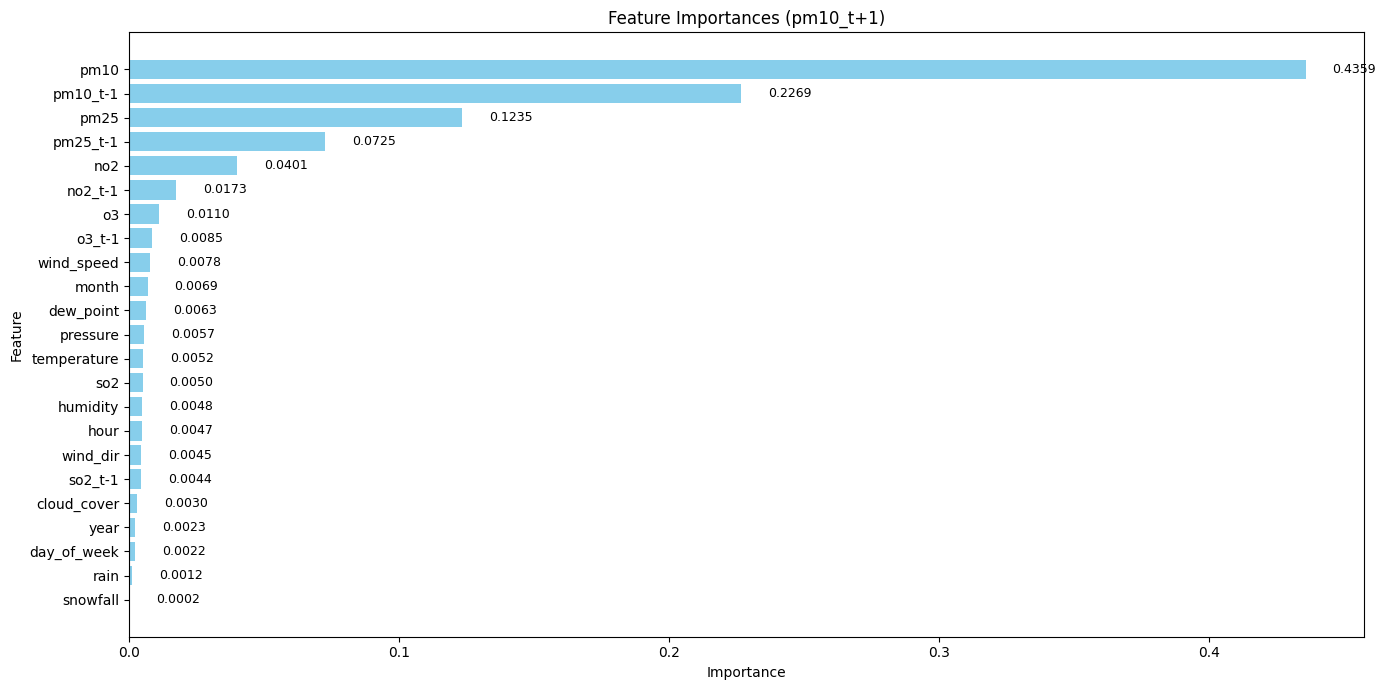

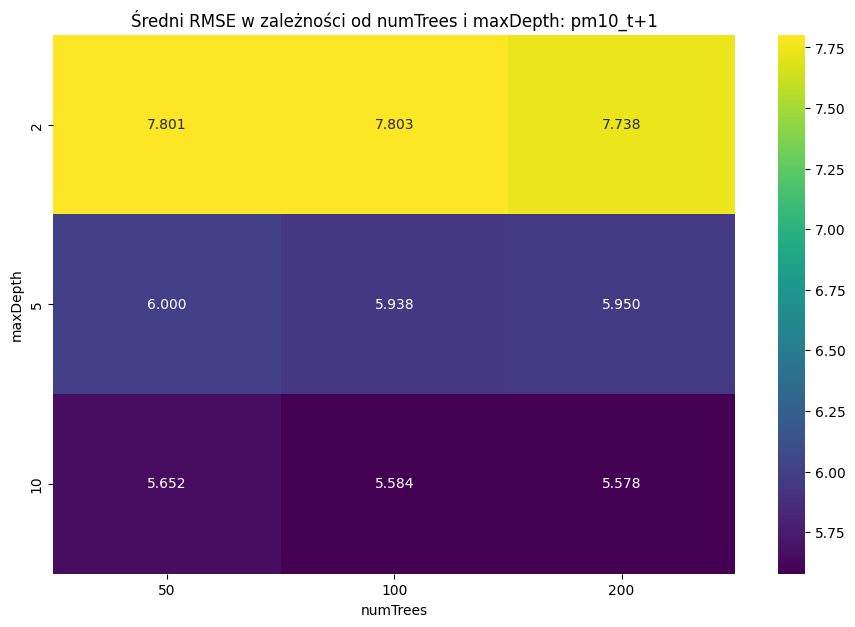

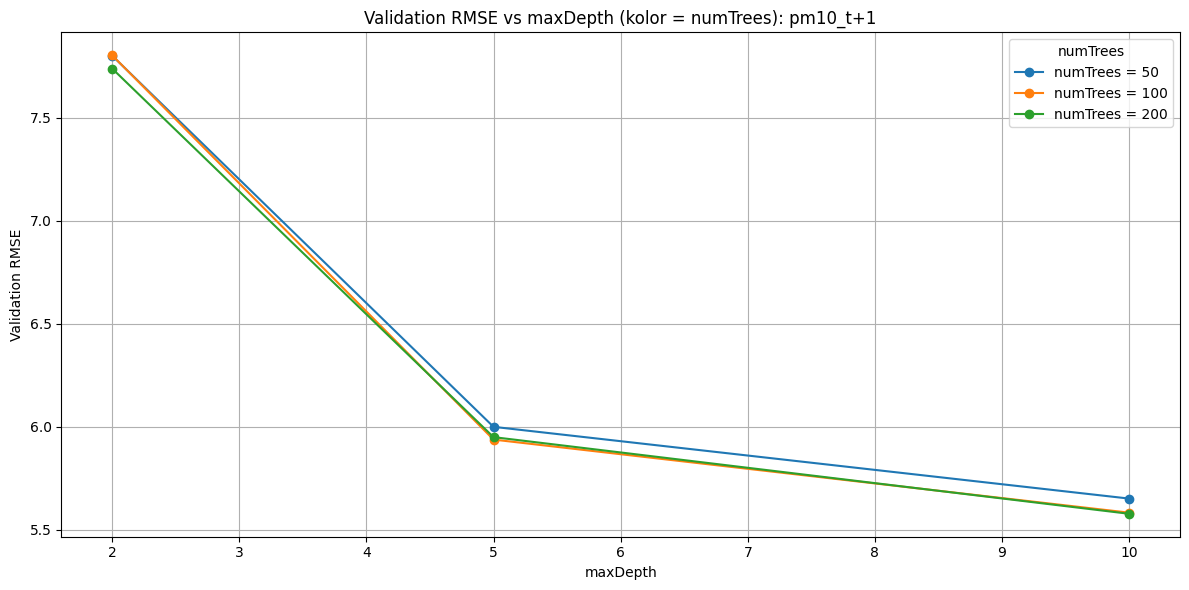

In [4]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

target_col = "pm10_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=10.2974, R2=0.6156
 Fold 2: RMSE=9.8081, R2=0.6399
 Fold 3: RMSE=5.6190, R2=0.7792
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 8.5748
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.6782

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=7.3107, R2=0.8063
 Fold 2: RMSE=7.4745, R2=0.7908
 Fold 3: RMSE=4.2041, R2=0.8764
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 6.3298
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.8245

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 07:58:57 WARN DAGScheduler: Broadcasting large task binary with size 1117.6 KiB
25/05/31 07:58:58 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 07:58:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 07:59:01 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 07:59:02 WARN DAGScheduler: Broadcasting large task binary with size 1550.5 KiB
                                                                                

 Fold 1: RMSE=6.6575, R2=0.8393


25/05/31 07:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1126.4 KiB
25/05/31 07:59:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:59:11 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 07:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1056.9 KiB
25/05/31 07:59:13 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 07:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1782.6 KiB
                                                                                

 Fold 2: RMSE=6.7906, R2=0.8274


25/05/31 07:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1127.5 KiB
25/05/31 07:59:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 07:59:24 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1114.3 KiB
25/05/31 07:59:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 07:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1944.8 KiB
                                                                                

 Fold 3: RMSE=3.9316, R2=0.8919
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.7932
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8529

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=10.3438, R2=0.6122
 Fold 2: RMSE=9.8156, R2=0.6393


 Fold 3: RMSE=5.6379, R2=0.7777
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 8.5991
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.6764

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=7.3126, R2=0.8062
 Fold 2: RMSE=7.4506, R2=0.7922


 Fold 3: RMSE=4.1896, R2=0.8772
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 6.3176
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.8252

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:00:04 WARN DAGScheduler: Broadcasting large task binary with size 1120.3 KiB
25/05/31 08:00:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:00:06 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1125.9 KiB
25/05/31 08:00:09 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 08:00:10 WARN DAGScheduler: Broadcasting large task binary with size 1949.3 KiB
25/05/31 08:00:12 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/05/31 08:00:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

 Fold 1: RMSE=6.5666, R2=0.8437


25/05/31 08:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1119.7 KiB
25/05/31 08:00:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1171.4 KiB
25/05/31 08:00:30 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:00:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:00:35 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
25/05/31 08:00:38 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=6.7944, R2=0.8272


25/05/31 08:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1120.3 KiB
25/05/31 08:00:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:00:54 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:00:56 WARN DAGScheduler: Broadcasting large task binary with size 1198.3 KiB
25/05/31 08:00:58 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:01:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:01:04 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
25/05/31 08:01:09 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=3.9094, R2=0.8931
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.7568
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8547

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=10.2310, R2=0.6206


 Fold 2: RMSE=9.7075, R2=0.6472


 Fold 3: RMSE=5.5899, R2=0.7815
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 8.5095
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.6831

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
                                                                                

 Fold 1: RMSE=7.2660, R2=0.8086


25/05/31 08:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
                                                                                

 Fold 2: RMSE=7.4207, R2=0.7938


25/05/31 08:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
                                                                                

 Fold 3: RMSE=4.1628, R2=0.8788
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 6.2832
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.8271

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:02:01 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
25/05/31 08:02:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:02:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1195.1 KiB
25/05/31 08:02:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:02:13 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 08:02:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:02:21 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB
25/05/31 08:02:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:02:30 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
25/05/31 08:02:31 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=6.5278, R2=0.8455


25/05/31 08:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
25/05/31 08:02:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:02:47 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:02:50 WARN DAGScheduler: Broadcasting large task binary with size 1219.0 KiB
25/05/31 08:02:51 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:02:55 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:02:58 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
25/05/31 08:03:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:03:10 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/05/31 08:03:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:03:22 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
25/05/31 08:03:24 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=6.7393, R2=0.8300


25/05/31 08:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
25/05/31 08:03:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:03:45 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1231.4 KiB
25/05/31 08:03:51 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:03:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:03:59 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
25/05/31 08:04:09 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:04:15 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 08:04:23 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:04:28 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
25/05/31 08:04:31 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=3.8842, R2=0.8945
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.7171
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8567
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.717097547538273


25/05/31 08:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1088.3 KiB
25/05/31 08:04:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:04:55 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:05:01 WARN DAGScheduler: Broadcasting large task binary with size 1233.8 KiB
25/05/31 08:05:03 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:05:10 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:05:13 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
25/05/31 08:05:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/31 08:05:30 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/05/31 08:05:38 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:05:44 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
25/05/31 08:05:48 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10_log


Test set RMSE: 6.5044
Test set R2: 0.8620


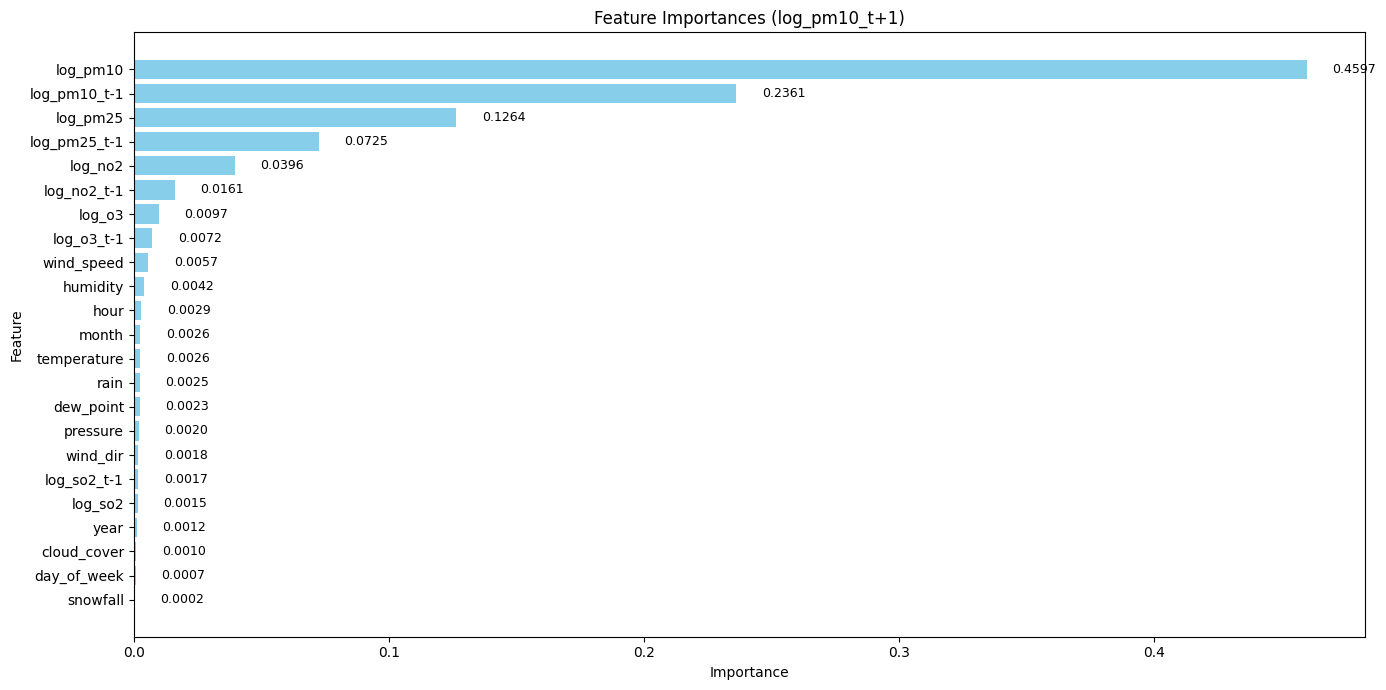

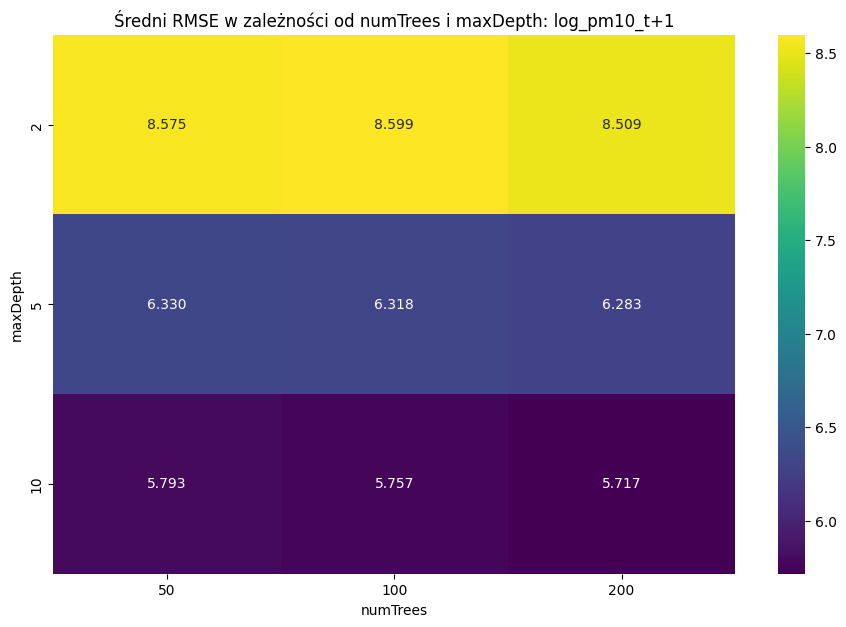

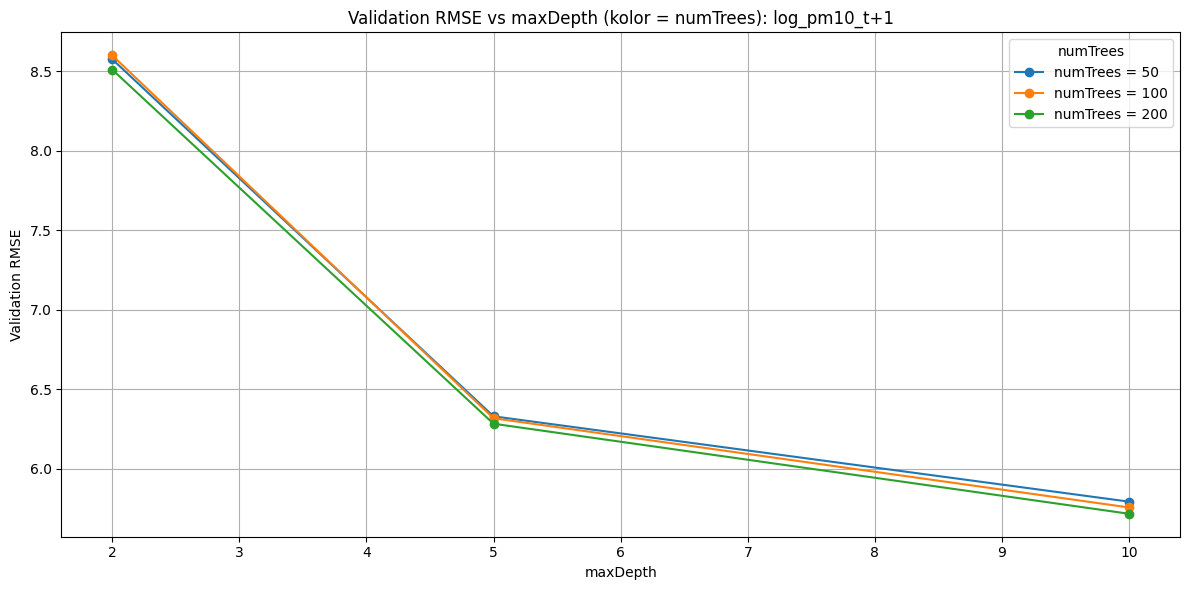

In [6]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "log_pm10_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10_log"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    is_log=True,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=6.3089, R2=0.7799
 Fold 2: RMSE=4.3680, R2=0.8309
 Fold 3: RMSE=3.9194, R2=0.8525
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 4.8654
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.8211

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=4.1052, R2=0.9068
 Fold 2: RMSE=3.1065, R2=0.9145
 Fold 3: RMSE=3.0415, R2=0.9112
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 3.4178
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.9108

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1111.1 KiB
25/05/31 08:06:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:06:24 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 08:06:26 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
25/05/31 08:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1557.4 KiB
                                                                                

 Fold 1: RMSE=3.7154, R2=0.9237


25/05/31 08:06:34 WARN DAGScheduler: Broadcasting large task binary with size 1125.9 KiB
25/05/31 08:06:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:06:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:06:37 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
25/05/31 08:06:38 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 08:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1769.2 KiB
                                                                                

 Fold 2: RMSE=2.8244, R2=0.9293


25/05/31 08:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1126.4 KiB
25/05/31 08:06:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:06:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1116.5 KiB
25/05/31 08:06:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 08:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1969.8 KiB
                                                                                

 Fold 3: RMSE=2.8483, R2=0.9221
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 3.1294
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9250

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=6.3388, R2=0.7778
 Fold 2: RMSE=4.3464, R2=0.8326


 Fold 3: RMSE=3.9329, R2=0.8515
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 4.8727
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.8206

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=3.9664, R2=0.9130


 Fold 2: RMSE=3.0652, R2=0.9167


 Fold 3: RMSE=3.0429, R2=0.9111
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 3.3582
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.9136

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1116.3 KiB
25/05/31 08:07:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:07:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
25/05/31 08:07:32 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 08:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1914.0 KiB
25/05/31 08:07:36 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/05/31 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

 Fold 1: RMSE=3.5898, R2=0.9287


25/05/31 08:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1119.1 KiB
25/05/31 08:07:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:07:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1158.8 KiB
25/05/31 08:07:53 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:07:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:07:58 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
25/05/31 08:08:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=2.7830, R2=0.9314


25/05/31 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1119.4 KiB
25/05/31 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:08:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1191.3 KiB
25/05/31 08:08:20 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:08:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:08:25 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 08:08:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=2.8215, R2=0.9236
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 3.0648
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9279

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=6.3221, R2=0.7790


 Fold 2: RMSE=4.3088, R2=0.8355


 Fold 3: RMSE=3.8620, R2=0.8568
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 4.8309
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.8238

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
                                                                                

 Fold 1: RMSE=3.9612, R2=0.9132


25/05/31 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 2: RMSE=3.0558, R2=0.9173


25/05/31 08:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
                                                                                

 Fold 3: RMSE=3.0563, R2=0.9103
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 3.3578
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.9136

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
25/05/31 08:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:09:23 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
25/05/31 08:09:26 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:09:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:09:31 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
25/05/31 08:09:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:09:38 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
25/05/31 08:09:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:09:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
25/05/31 08:09:48 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=3.6026, R2=0.9282


25/05/31 08:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 08:10:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:10:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1209.5 KiB
25/05/31 08:10:07 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:10:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:10:14 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 08:10:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/05/31 08:10:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:10:36 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
25/05/31 08:10:38 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=2.7738, R2=0.9318


25/05/31 08:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
25/05/31 08:10:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:10:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1225.3 KiB
25/05/31 08:11:03 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:11:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
25/05/31 08:11:20 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:11:26 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
25/05/31 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:11:38 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
25/05/31 08:11:41 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=2.8343, R2=0.9229
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 3.0702
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9276
Najlepsze parametry: {'numTrees': 100, 'maxDepth': 10} z RMSE: 3.0647832370984656


25/05/31 08:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB
25/05/31 08:11:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:12:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1202.6 KiB
25/05/31 08:12:04 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:12:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:12:11 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
25/05/31 08:12:18 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:12:24 WARN TaskSetManager: Stage 5343 contains a task of very large size (6658 KiB). The maximum recommended task size is 1000 KiB.


Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25
Test set RMSE: 3.3940
Test set R2: 0.9353


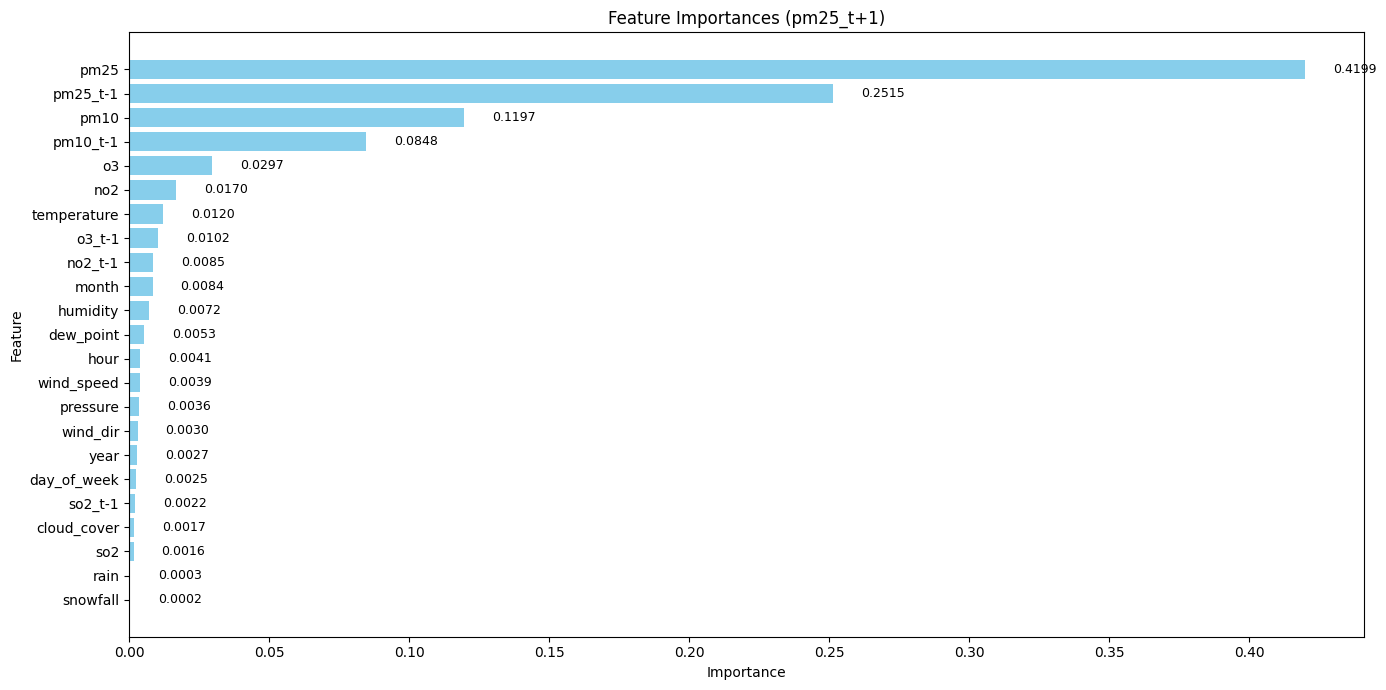

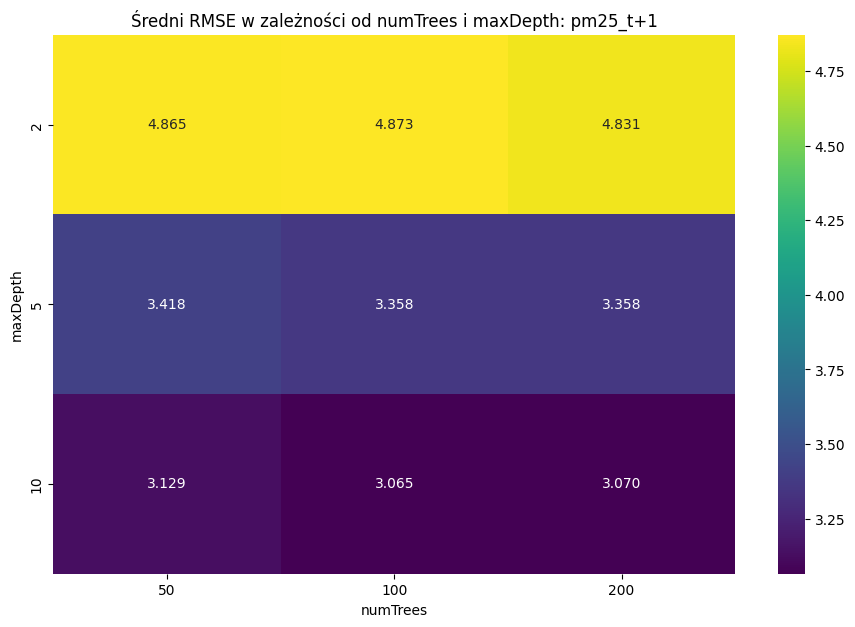

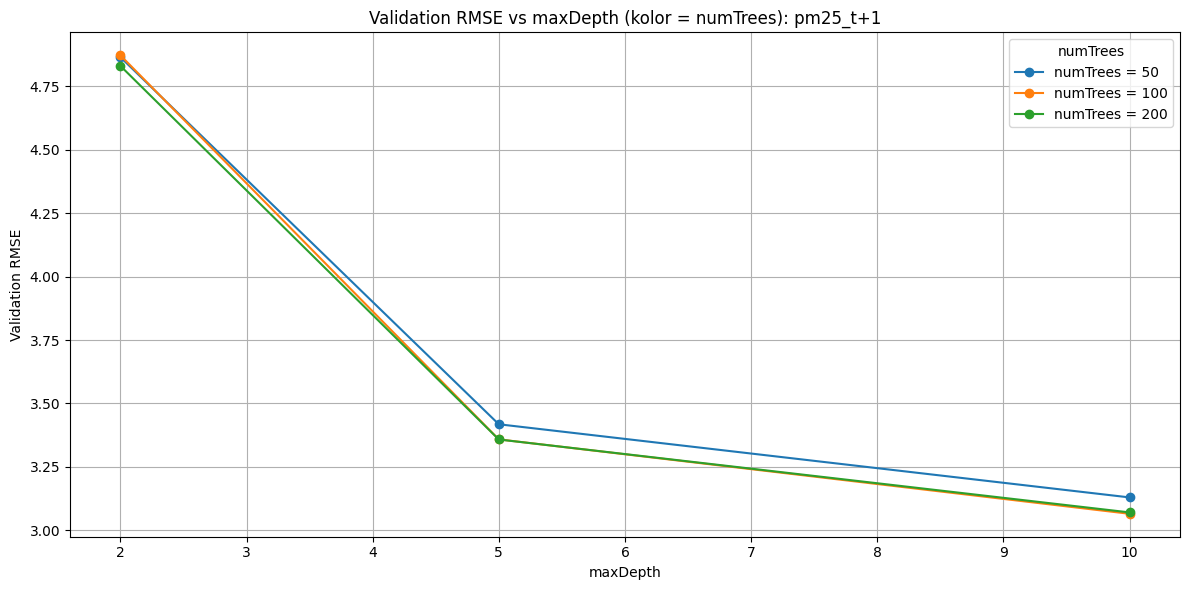

In [7]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

target_col = "pm25_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=7.2203, R2=0.7117
 Fold 2: RMSE=4.4193, R2=0.8269
 Fold 3: RMSE=4.9833, R2=0.7616
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 5.5410
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.7668

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=4.6013, R2=0.8829
 Fold 2: RMSE=2.9666, R2=0.9220
 Fold 3: RMSE=3.1698, R2=0.9035
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 3.5792
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.9028

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1119.0 KiB
25/05/31 08:12:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:12:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
25/05/31 08:12:56 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
25/05/31 08:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1626.6 KiB
                                                                                

 Fold 1: RMSE=3.7610, R2=0.9218


25/05/31 08:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1125.9 KiB
25/05/31 08:13:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:13:06 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1097.3 KiB
25/05/31 08:13:08 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 08:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1885.1 KiB
                                                                                

 Fold 2: RMSE=2.7827, R2=0.9314


25/05/31 08:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1128.9 KiB
25/05/31 08:13:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:13:19 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
25/05/31 08:13:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 08:13:23 WARN DAGScheduler: Broadcasting large task binary with size 2042.5 KiB
                                                                                

 Fold 3: RMSE=2.9324, R2=0.9175
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 3.1587
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9235

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=7.2054, R2=0.7129
 Fold 2: RMSE=4.4215, R2=0.8268


 Fold 3: RMSE=4.9842, R2=0.7615
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 5.5370
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.7671

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=4.5984, R2=0.8831


 Fold 2: RMSE=2.9844, R2=0.9211


 Fold 3: RMSE=3.2126, R2=0.9009
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 3.5985
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.9017

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:13:58 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
25/05/31 08:13:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:14:00 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1142.2 KiB
25/05/31 08:14:02 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/05/31 08:14:04 WARN DAGScheduler: Broadcasting large task binary with size 2014.6 KiB
25/05/31 08:14:06 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
25/05/31 08:14:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
                                                                                

 Fold 1: RMSE=3.7318, R2=0.9230


25/05/31 08:14:17 WARN DAGScheduler: Broadcasting large task binary with size 1120.1 KiB
25/05/31 08:14:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:14:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1187.0 KiB
25/05/31 08:14:23 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:14:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:14:28 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
25/05/31 08:14:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
                                                                                

 Fold 2: RMSE=2.7226, R2=0.9343


25/05/31 08:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1120.1 KiB
25/05/31 08:14:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:14:48 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1209.2 KiB
25/05/31 08:14:51 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:14:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:14:57 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
25/05/31 08:15:02 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
                                                                                

 Fold 3: RMSE=2.9455, R2=0.9167
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 3.1333
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9247

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=7.2072, R2=0.7128


 Fold 2: RMSE=4.3893, R2=0.8293


 Fold 3: RMSE=5.0092, R2=0.7591
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 5.5352
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.7671

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
                                                                                

 Fold 1: RMSE=4.5736, R2=0.8843


25/05/31 08:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
                                                                                

 Fold 2: RMSE=2.9745, R2=0.9216


25/05/31 08:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
                                                                                

 Fold 3: RMSE=3.2057, R2=0.9013
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 3.5846
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.9024

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
25/05/31 08:15:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:15:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1202.5 KiB
25/05/31 08:16:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:16:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:16:06 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
25/05/31 08:16:10 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:16:15 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
25/05/31 08:16:19 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:16:24 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 08:16:25 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=3.7085, R2=0.9240


25/05/31 08:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
25/05/31 08:16:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:16:41 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1224.1 KiB
25/05/31 08:16:46 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:16:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:16:53 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
25/05/31 08:16:59 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
25/05/31 08:17:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:17:17 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
25/05/31 08:17:19 WARN DAGScheduler: Broadcas

 Fold 2: RMSE=2.7299, R2=0.9340


25/05/31 08:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
25/05/31 08:17:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:17:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:17:43 WARN DAGScheduler: Broadcasting large task binary with size 1231.7 KiB
25/05/31 08:17:45 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:17:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:17:53 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
25/05/31 08:18:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/31 08:18:08 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
25/05/31 08:18:17 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:18:22 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
25/05/31 08:18:25 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=2.9315, R2=0.9175
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 3.1233
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9251
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 3.123319097329991


25/05/31 08:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
25/05/31 08:18:46 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:18:51 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:18:57 WARN DAGScheduler: Broadcasting large task binary with size 1234.4 KiB
25/05/31 08:18:58 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:19:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 08:19:09 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 08:19:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 08:19:25 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
25/05/31 08:19:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:19:39 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/05/31 08:19:44 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25_log


Test set RMSE: 3.4677
Test set R2: 0.9324


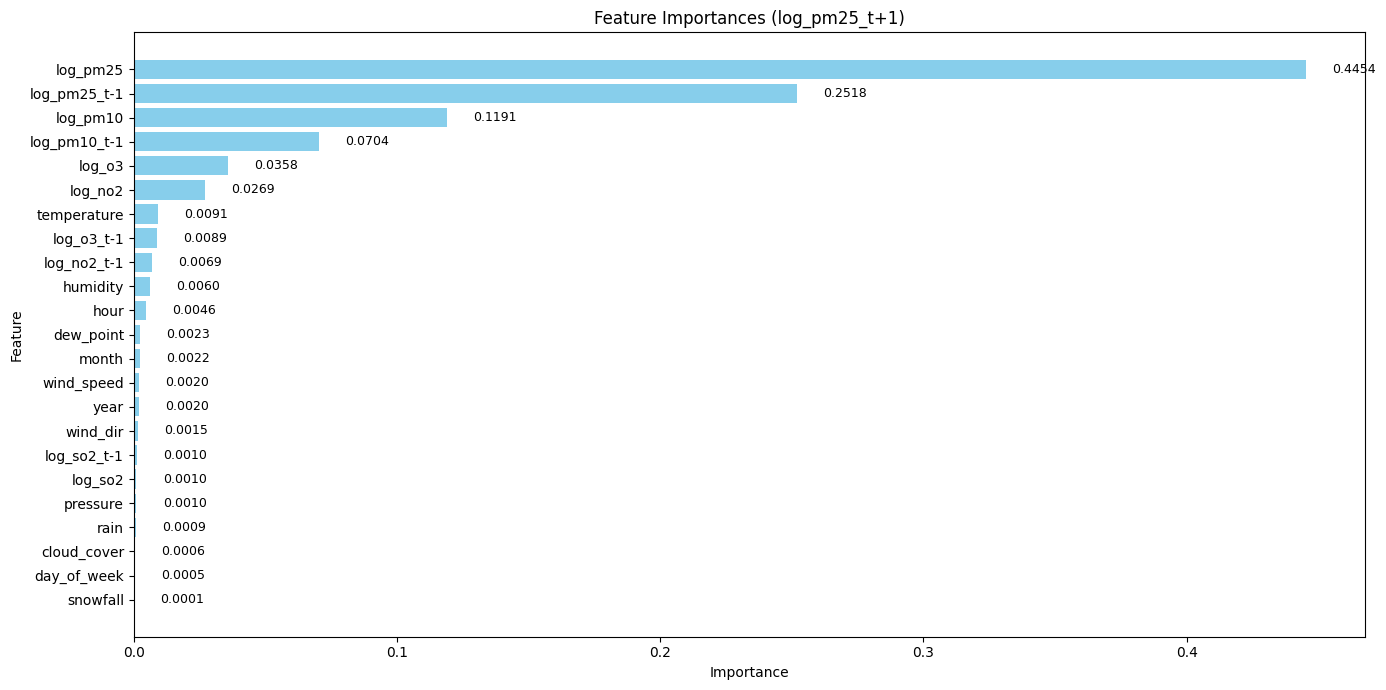

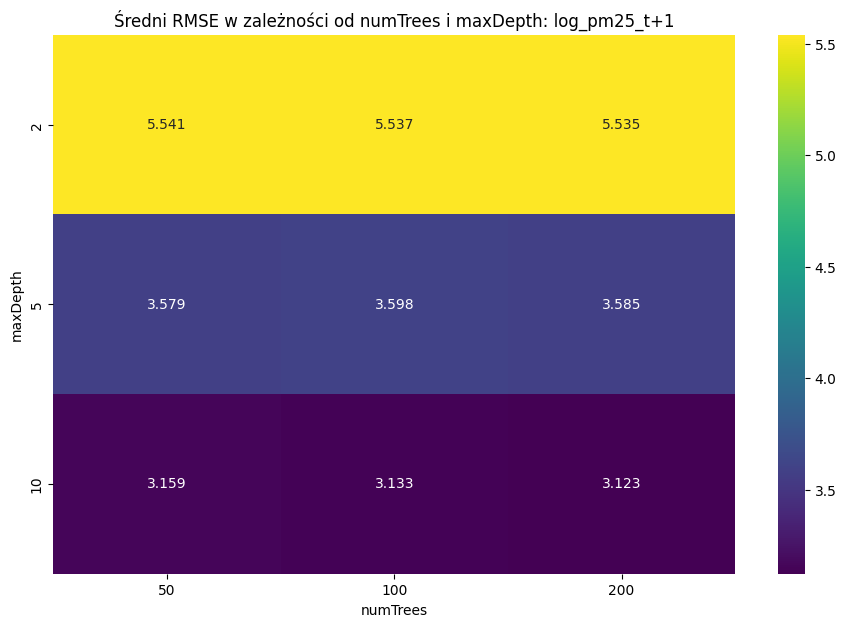

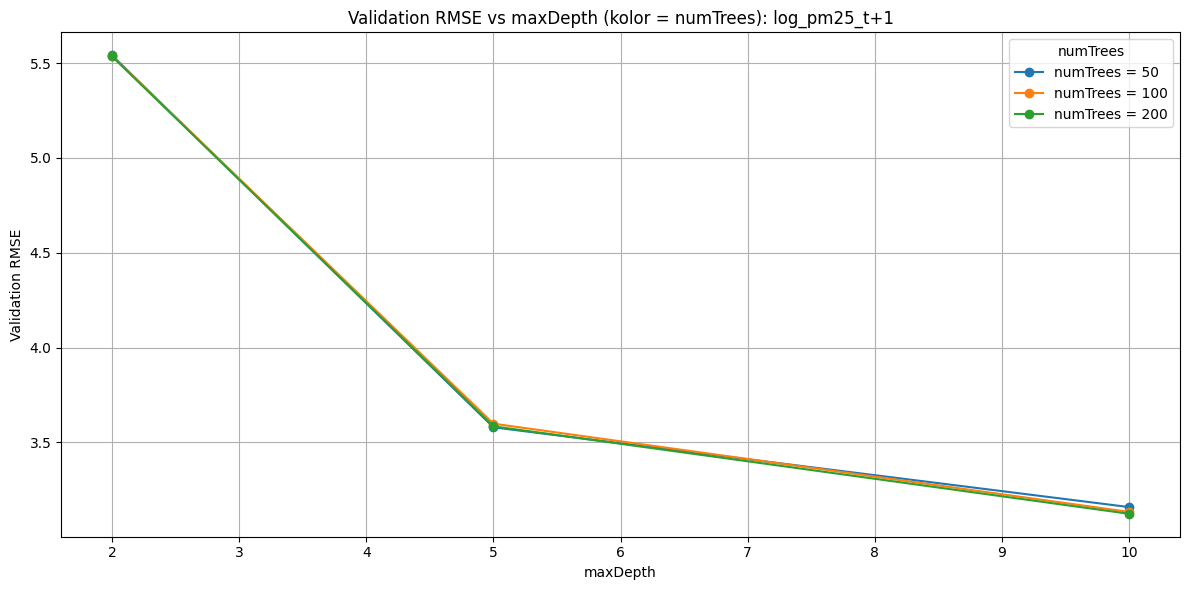

In [8]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "log_pm25_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25_log"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    is_log=True,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=9.3675, R2=0.5913
 Fold 2: RMSE=10.0471, R2=0.5918
 Fold 3: RMSE=8.4485, R2=0.6290
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 9.2877
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.6040

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=6.8809, R2=0.7795
 Fold 2: RMSE=7.1081, R2=0.7957
 Fold 3: RMSE=6.0763, R2=0.8081
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 6.6884
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.7944

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1104.7 KiB
25/05/31 08:20:19 WARN DAGScheduler: Broadcasting large task binary with size 2018.9 KiB
25/05/31 08:20:20 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 08:20:21 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 08:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1470.2 KiB
                                                                                

 Fold 1: RMSE=5.9947, R2=0.8326


25/05/31 08:20:28 WARN DAGScheduler: Broadcasting large task binary with size 1127.4 KiB
25/05/31 08:20:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1058.1 KiB
25/05/31 08:20:33 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 08:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
                                                                                

 Fold 2: RMSE=5.8193, R2=0.8630


25/05/31 08:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1128.7 KiB
25/05/31 08:20:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:20:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
25/05/31 08:20:47 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 08:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1948.0 KiB
                                                                                

 Fold 3: RMSE=5.0617, R2=0.8668
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.6252
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8542

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=9.2677, R2=0.6000
 Fold 2: RMSE=9.9770, R2=0.5974
 Fold 3: RMSE=8.2905, R2=0.6427
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 9.1784
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.6134

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=6.8467, R2=0.7817


 Fold 2: RMSE=7.1097, R2=0.7956


 Fold 3: RMSE=6.0407, R2=0.8103
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 6.6657
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.7959

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
25/05/31 08:21:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:21:23 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1087.5 KiB
25/05/31 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
25/05/31 08:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1883.5 KiB
25/05/31 08:21:29 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
25/05/31 08:21:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

 Fold 1: RMSE=5.9295, R2=0.8363


25/05/31 08:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1121.0 KiB
25/05/31 08:21:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1165.8 KiB
25/05/31 08:21:46 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:21:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:21:51 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
25/05/31 08:21:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=5.8303, R2=0.8625


25/05/31 08:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1120.2 KiB
25/05/31 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:22:10 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1188.3 KiB
25/05/31 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:22:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:22:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 08:22:25 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=5.0203, R2=0.8690
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.5933
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8559

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=9.1702, R2=0.6084


 Fold 2: RMSE=9.8522, R2=0.6074


 Fold 3: RMSE=8.1983, R2=0.6506
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 9.0736
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.6221

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
                                                                                

 Fold 1: RMSE=6.8218, R2=0.7833


25/05/31 08:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1102.0 KiB
                                                                                

 Fold 2: RMSE=7.0683, R2=0.7979


25/05/31 08:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
                                                                                

 Fold 3: RMSE=5.9957, R2=0.8131
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 6.6286
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.7981

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
25/05/31 08:23:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:23:17 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1168.3 KiB
25/05/31 08:23:21 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:23:25 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
25/05/31 08:23:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 08:23:33 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB
25/05/31 08:23:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:23:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 08:23:43 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=5.9418, R2=0.8356


25/05/31 08:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1102.0 KiB
25/05/31 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
25/05/31 08:24:04 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:24:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:24:11 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
25/05/31 08:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:24:22 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/05/31 08:24:28 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:24:33 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
25/05/31 08:24:35 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=5.8167, R2=0.8632


25/05/31 08:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
25/05/31 08:24:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:24:54 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1224.7 KiB
25/05/31 08:25:00 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:25:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:25:09 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
25/05/31 08:25:18 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:25:24 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
25/05/31 08:25:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:25:37 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
25/05/31 08:25:40 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=5.0039, R2=0.8698
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.5874
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8562
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.5874386711866455


25/05/31 08:25:55 WARN DAGScheduler: Broadcasting large task binary with size 1088.6 KiB
25/05/31 08:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1232.8 KiB
25/05/31 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:26:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 08:26:33 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/31 08:26:39 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/05/31 08:26:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:26:53 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
25/05/31 08:26:57 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2


Test set RMSE: 5.5068
Test set R2: 0.8676


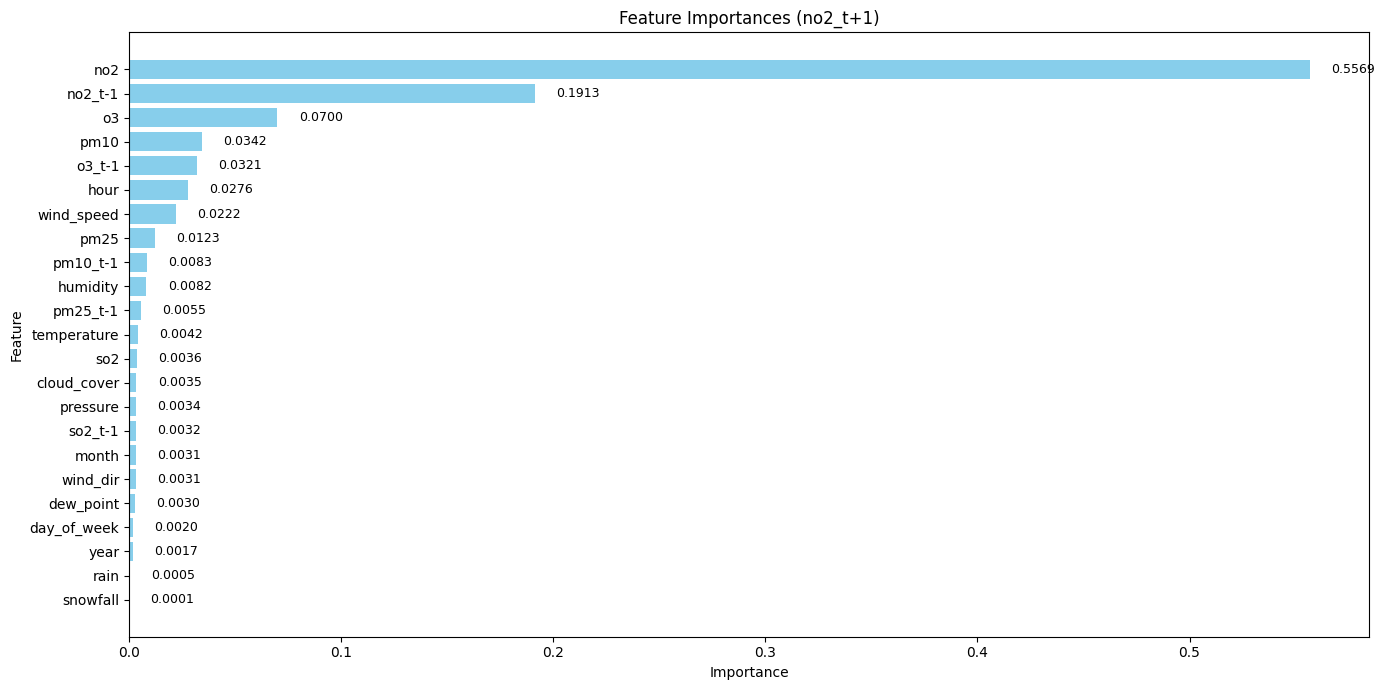

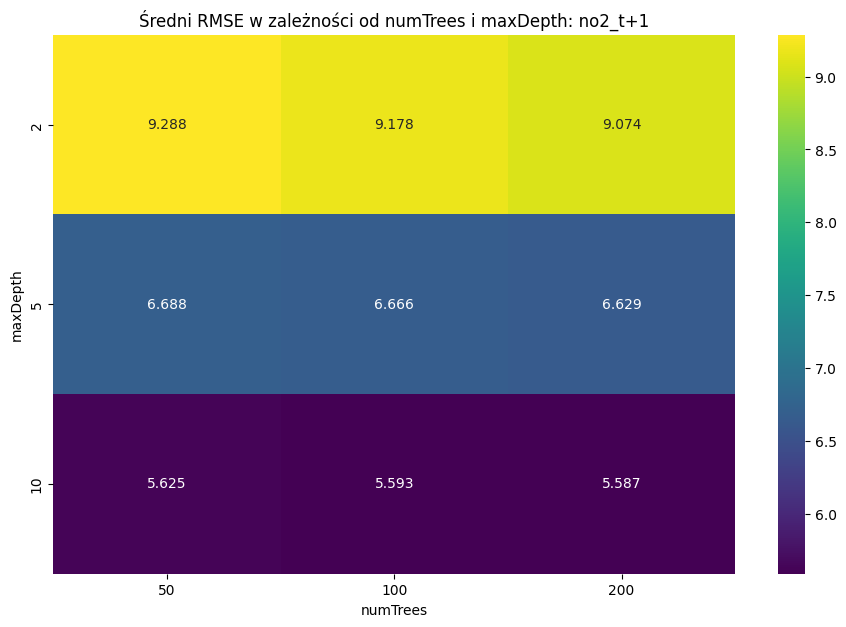

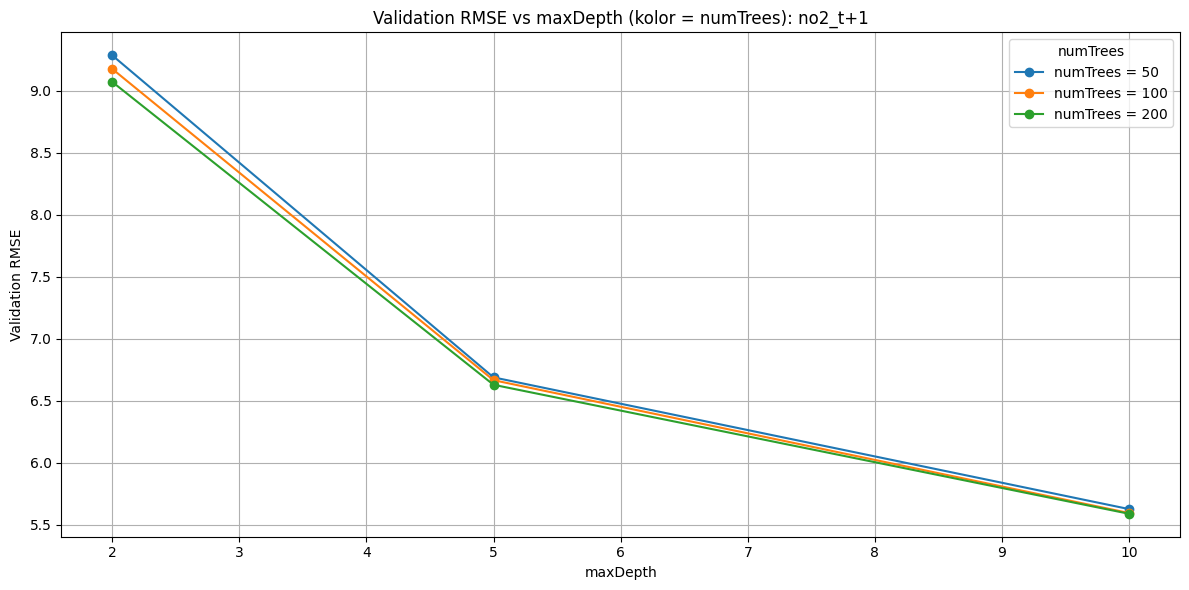

In [9]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

target_col = "no2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=10.1063, R2=0.5243
 Fold 2: RMSE=11.0705, R2=0.5044
 Fold 3: RMSE=9.1579, R2=0.5640
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 10.1116
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.5309

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=7.3495, R2=0.7484
 Fold 2: RMSE=7.8912, R2=0.7482
 Fold 3: RMSE=6.5612, R2=0.7762
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 7.2673
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.7576

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1126.7 KiB
25/05/31 08:27:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:27:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
25/05/31 08:27:37 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
25/05/31 08:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1627.6 KiB
                                                                                

 Fold 1: RMSE=6.1197, R2=0.8256


25/05/31 08:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1129.9 KiB
25/05/31 08:27:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:27:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1128.0 KiB
25/05/31 08:27:49 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/05/31 08:27:50 WARN DAGScheduler: Broadcasting large task binary with size 1974.3 KiB
                                                                                

 Fold 2: RMSE=6.0678, R2=0.8511


25/05/31 08:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1129.9 KiB
25/05/31 08:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:28:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1167.3 KiB
25/05/31 08:28:03 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:28:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

 Fold 3: RMSE=5.2559, R2=0.8564
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.8144
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8444

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=10.0578, R2=0.5289
 Fold 2: RMSE=11.1318, R2=0.4989


 Fold 3: RMSE=9.2151, R2=0.5586
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 10.1349
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.5288

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=7.4090, R2=0.7444


 Fold 2: RMSE=7.9765, R2=0.7427


 Fold 3: RMSE=6.5923, R2=0.7741
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 7.3259
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.7537

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1121.3 KiB
25/05/31 08:28:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:28:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1147.7 KiB
25/05/31 08:28:44 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 08:28:46 WARN DAGScheduler: Broadcasting large task binary with size 2022.3 KiB
25/05/31 08:28:48 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
25/05/31 08:28:50 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
                                                                                

 Fold 1: RMSE=6.0816, R2=0.8278


25/05/31 08:29:00 WARN DAGScheduler: Broadcasting large task binary with size 1121.8 KiB
25/05/31 08:29:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:29:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1194.1 KiB
25/05/31 08:29:06 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:29:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:29:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 08:29:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 2: RMSE=6.0925, R2=0.8499


25/05/31 08:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1121.3 KiB
25/05/31 08:29:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:29:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:29:33 WARN DAGScheduler: Broadcasting large task binary with size 1218.2 KiB
25/05/31 08:29:35 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:29:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:29:41 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
25/05/31 08:29:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
                                                                                

 Fold 3: RMSE=5.2079, R2=0.8590
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.7940
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8455

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=9.9255, R2=0.5412


 Fold 2: RMSE=10.9174, R2=0.5180


 Fold 3: RMSE=9.0273, R2=0.5764
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 9.9567
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.5452

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
                                                                                

 Fold 1: RMSE=7.3110, R2=0.7511


25/05/31 08:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
                                                                                

 Fold 2: RMSE=7.8393, R2=0.7515


25/05/31 08:30:30 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
                                                                                

 Fold 3: RMSE=6.4951, R2=0.7807
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 7.2151
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.7611

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
25/05/31 08:30:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:30:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1215.9 KiB
25/05/31 08:30:45 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:30:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:30:51 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
25/05/31 08:30:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:31:00 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
25/05/31 08:31:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:31:09 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 08:31:10 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=6.0782, R2=0.8279


25/05/31 08:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
25/05/31 08:31:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:31:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1235.5 KiB
25/05/31 08:31:30 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:31:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:31:37 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 08:31:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:31:51 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB
25/05/31 08:31:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:32:02 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
25/05/31 08:32:04 WARN DAGScheduler: Broadcas

 Fold 2: RMSE=6.0744, R2=0.8508


25/05/31 08:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
25/05/31 08:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:32:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1238.4 KiB
25/05/31 08:32:32 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 08:32:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 08:32:40 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 08:32:49 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/05/31 08:33:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:33:08 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
25/05/31 08:33:12 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=5.1809, R2=0.8605
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.7778
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8464
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.777806680125539


25/05/31 08:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
25/05/31 08:33:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:33:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1240.4 KiB
25/05/31 08:33:44 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 08:33:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 08:33:55 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
25/05/31 08:34:07 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
25/05/31 08:34:12 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB
25/05/31 08:34:20 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:34:25 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
25/05/31 08:34:30 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2_log


Test set RMSE: 5.6805
Test set R2: 0.8591


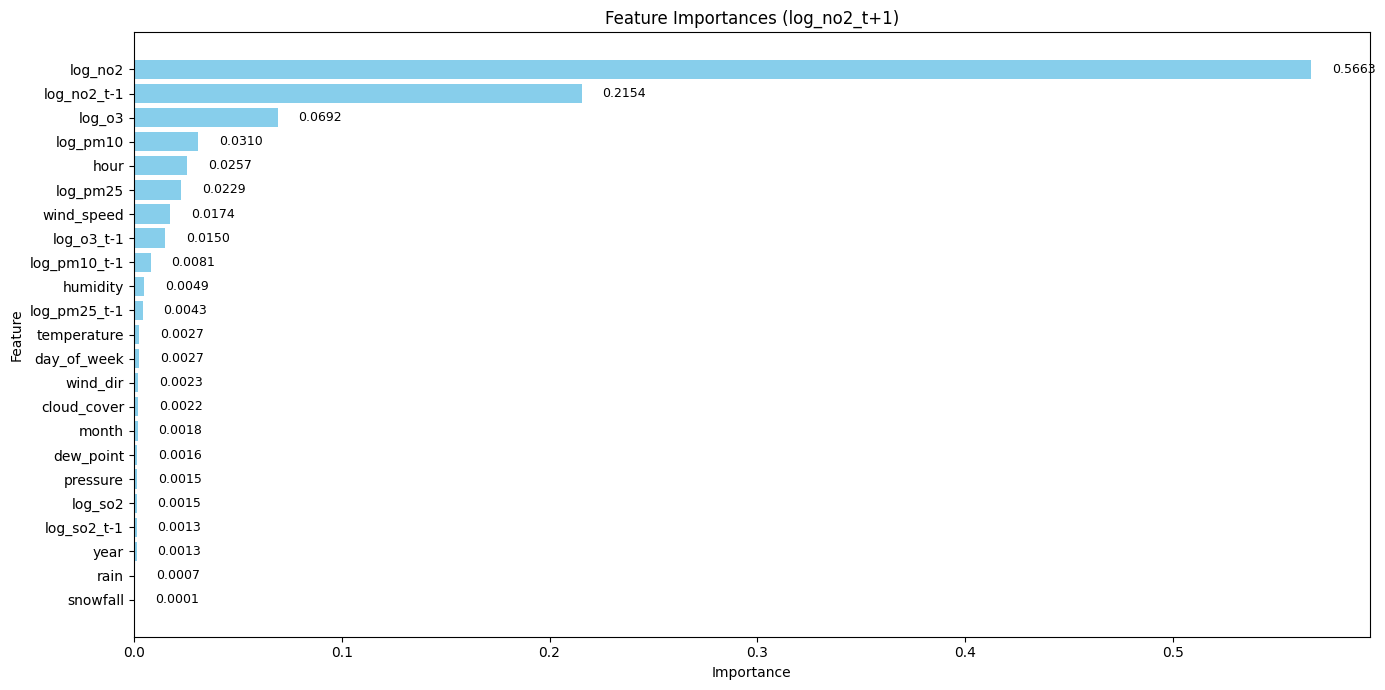

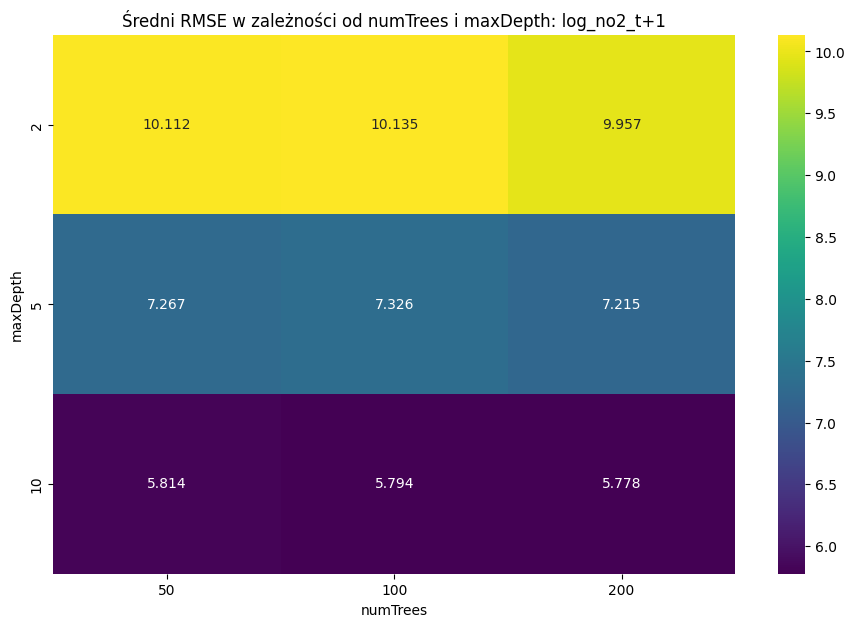

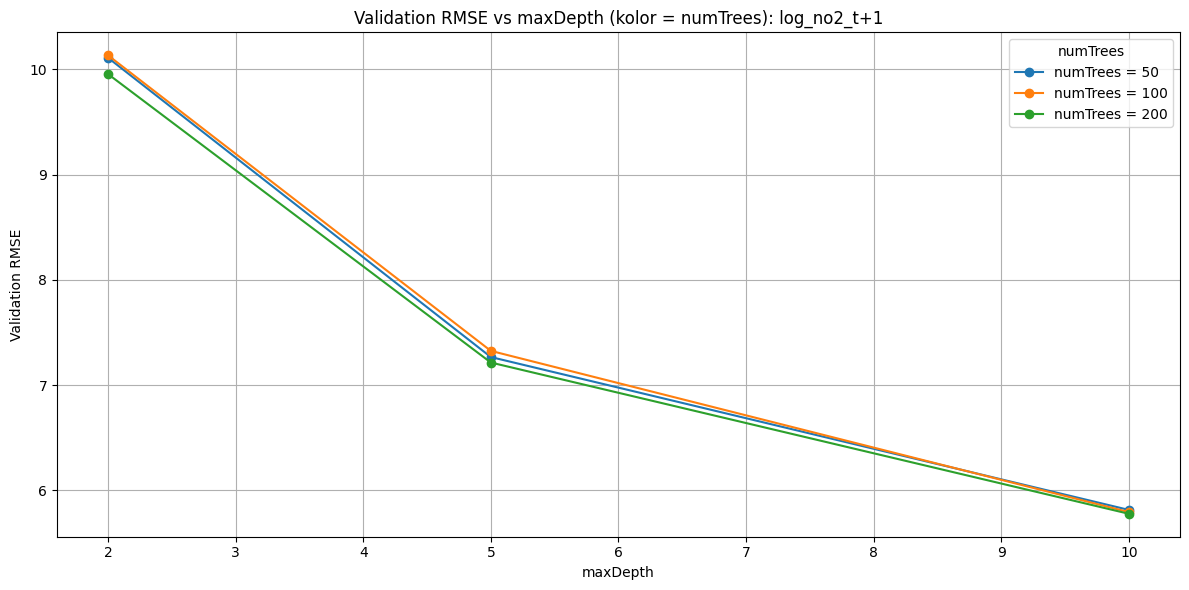

In [10]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "log_no2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2_log"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    is_log=True,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=13.4033, R2=0.8134
 Fold 2: RMSE=12.6555, R2=0.8001
 Fold 3: RMSE=11.8876, R2=0.8221
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 12.6488
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.8119

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=9.4835, R2=0.9066
 Fold 2: RMSE=9.1164, R2=0.8963
 Fold 3: RMSE=8.2842, R2=0.9136
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 8.9614
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.9055

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1123.5 KiB
25/05/31 08:35:06 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:35:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:35:09 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 08:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1564.4 KiB
                                                                                

 Fold 1: RMSE=7.9078, R2=0.9351


25/05/31 08:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
25/05/31 08:35:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:35:18 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1103.6 KiB
25/05/31 08:35:20 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 08:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1896.5 KiB
                                                                                

 Fold 2: RMSE=7.2883, R2=0.9337


25/05/31 08:35:29 WARN DAGScheduler: Broadcasting large task binary with size 1130.4 KiB
25/05/31 08:35:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:35:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1150.4 KiB
25/05/31 08:35:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 08:35:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
                                                                                

 Fold 3: RMSE=6.7473, R2=0.9427
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 7.3145
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9372

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=13.4710, R2=0.8115
 Fold 2: RMSE=12.8503, R2=0.7939


 Fold 3: RMSE=12.1318, R2=0.8147
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 12.8177
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.8067

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=9.5067, R2=0.9061


 Fold 2: RMSE=9.1488, R2=0.8955


 Fold 3: RMSE=8.3696, R2=0.9118
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 9.0084
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.9045

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1119.6 KiB
25/05/31 08:36:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:36:11 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
25/05/31 08:36:14 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/05/31 08:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1965.1 KiB
25/05/31 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
25/05/31 08:36:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
                                                                                

 Fold 1: RMSE=7.8690, R2=0.9357


25/05/31 08:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1119.6 KiB
25/05/31 08:36:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:36:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1190.3 KiB
25/05/31 08:36:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:36:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:36:40 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
25/05/31 08:36:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
                                                                                

 Fold 2: RMSE=7.2424, R2=0.9345


25/05/31 08:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB
25/05/31 08:36:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:36:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1214.5 KiB
25/05/31 08:37:04 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:37:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 08:37:14 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
                                                                                

 Fold 3: RMSE=6.7276, R2=0.9430
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 7.2796
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9378

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=13.7150, R2=0.8047


 Fold 2: RMSE=13.0386, R2=0.7878


 Fold 3: RMSE=12.3403, R2=0.8083
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 13.0313
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.8003

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
                                                                                

 Fold 1: RMSE=9.4746, R2=0.9068


25/05/31 08:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
                                                                                

 Fold 2: RMSE=9.0803, R2=0.8971


25/05/31 08:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1100.6 KiB
                                                                                

 Fold 3: RMSE=8.2848, R2=0.9136
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 8.9466
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.9058

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:38:05 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
25/05/31 08:38:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:38:08 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
25/05/31 08:38:11 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:38:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:38:16 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
25/05/31 08:38:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:38:25 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
25/05/31 08:38:29 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:38:34 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/05/31 08:38:35 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=7.8428, R2=0.9361


25/05/31 08:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1101.0 KiB
25/05/31 08:38:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:38:51 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1233.8 KiB
25/05/31 08:38:56 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:39:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:39:03 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
25/05/31 08:39:10 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:39:16 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
25/05/31 08:39:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:39:27 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
25/05/31 08:39:29 WARN DAGScheduler: Broadcas

 Fold 2: RMSE=7.2139, R2=0.9351


25/05/31 08:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1100.6 KiB
25/05/31 08:39:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:39:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1235.9 KiB
25/05/31 08:39:55 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 08:40:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 08:40:04 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 08:40:13 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 08:40:19 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
25/05/31 08:40:26 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:40:31 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
25/05/31 08:40:34 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=6.7165, R2=0.9432
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 7.2577
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9381
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 7.257734787000712


25/05/31 08:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
25/05/31 08:40:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:40:59 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1238.7 KiB
25/05/31 08:41:07 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 08:41:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 08:41:17 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 08:41:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 08:41:34 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
25/05/31 08:41:43 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:41:48 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
25/05/31 08:41:54 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3


Test set RMSE: 6.9389
Test set R2: 0.9450


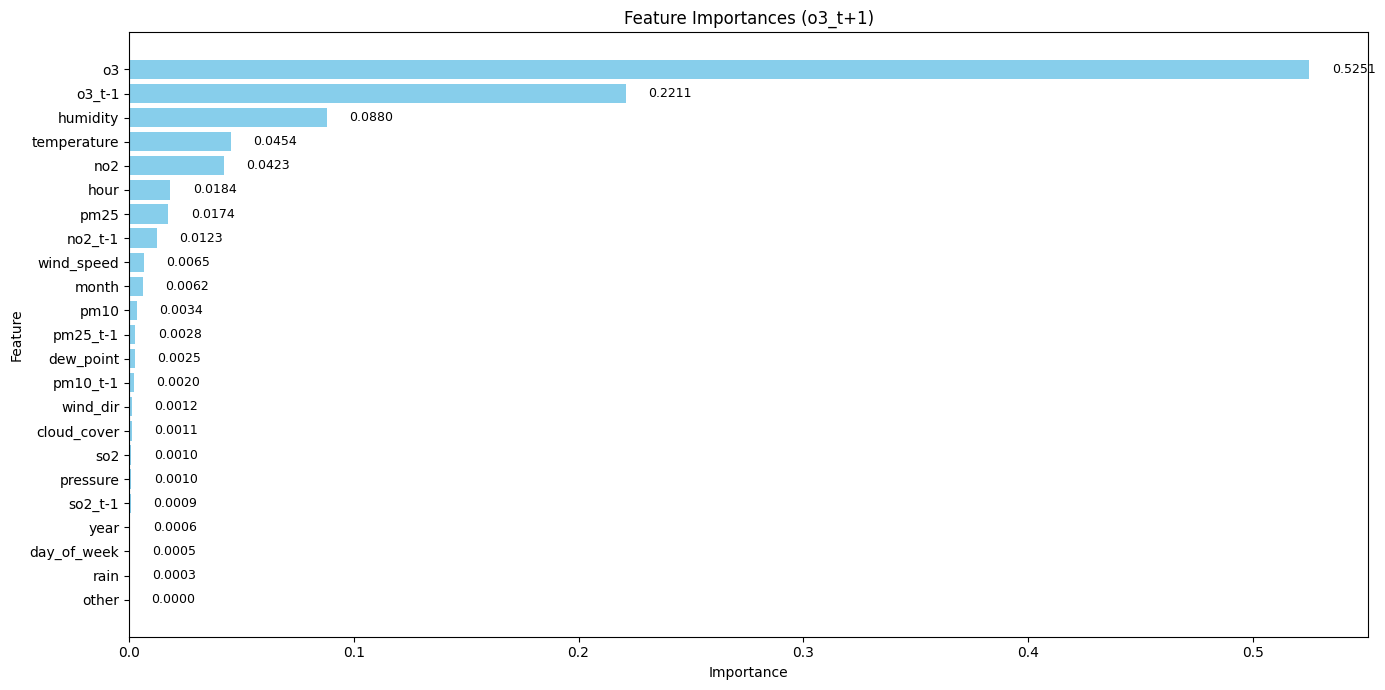

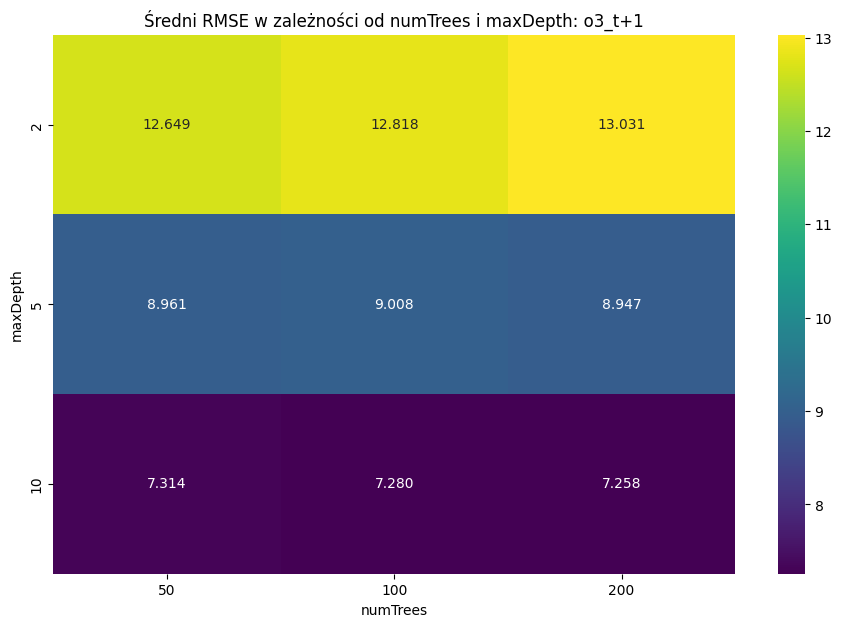

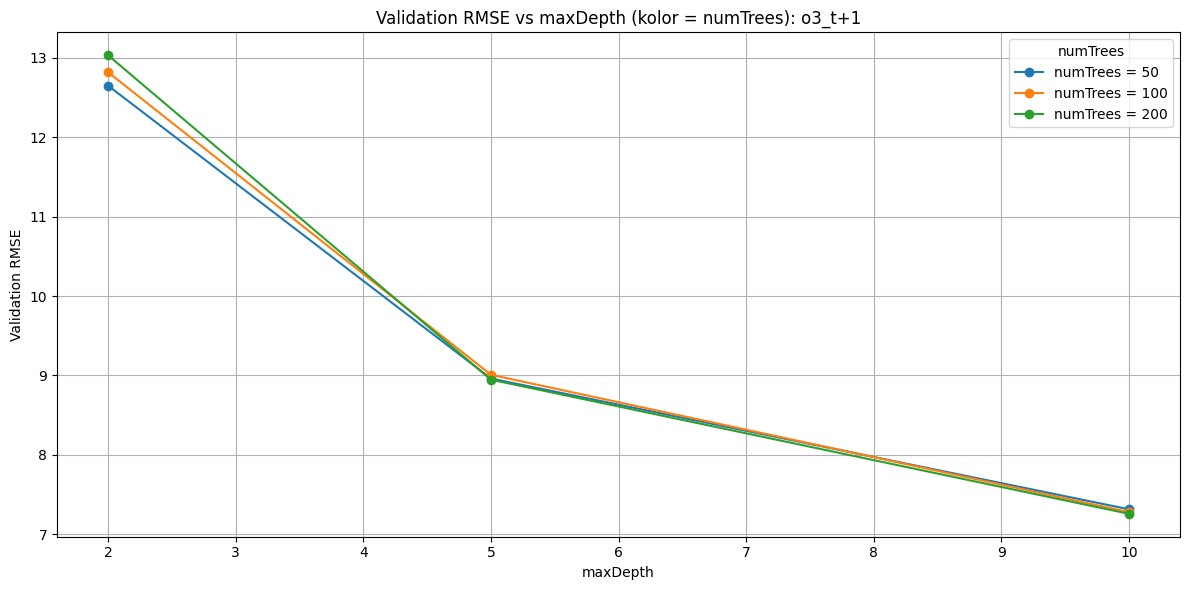

In [11]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

target_col = "o3_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=17.0282, R2=0.6989
 Fold 2: RMSE=15.2458, R2=0.7099
 Fold 3: RMSE=14.8606, R2=0.7220
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 15.7115
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.7103

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=10.2482, R2=0.8909
 Fold 2: RMSE=9.5361, R2=0.8865
 Fold 3: RMSE=8.8037, R2=0.9024
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 9.5293
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.8933

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
25/05/31 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:42:32 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 08:42:34 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/05/31 08:42:35 WARN DAGScheduler: Broadcasting large task binary with size 1494.6 KiB
                                                                                

 Fold 1: RMSE=8.3625, R2=0.9274


25/05/31 08:42:41 WARN DAGScheduler: Broadcasting large task binary with size 1127.0 KiB
25/05/31 08:42:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:42:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:42:44 WARN DAGScheduler: Broadcasting large task binary with size 1066.2 KiB
25/05/31 08:42:45 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 08:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1810.1 KiB
                                                                                

 Fold 2: RMSE=7.3634, R2=0.9323


25/05/31 08:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1129.0 KiB
25/05/31 08:42:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:42:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1122.3 KiB
25/05/31 08:42:59 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/05/31 08:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1982.3 KiB
                                                                                

 Fold 3: RMSE=6.9046, R2=0.9400
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 7.5435
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9332

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=16.8540, R2=0.7050
 Fold 2: RMSE=15.0250, R2=0.7183


 Fold 3: RMSE=14.5704, R2=0.7328
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 15.4831
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.7187

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=10.4864, R2=0.8858


 Fold 2: RMSE=9.6007, R2=0.8850


 Fold 3: RMSE=8.8947, R2=0.9004
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 9.6606
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.8904

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1119.3 KiB
25/05/31 08:43:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:43:38 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:43:39 WARN DAGScheduler: Broadcasting large task binary with size 1099.8 KiB
25/05/31 08:43:40 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 08:43:41 WARN DAGScheduler: Broadcasting large task binary with size 1881.1 KiB
25/05/31 08:43:44 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
25/05/31 08:43:45 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
                                                                                

 Fold 1: RMSE=8.4107, R2=0.9265


25/05/31 08:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1121.1 KiB
25/05/31 08:43:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:43:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1173.7 KiB
25/05/31 08:44:01 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:44:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:44:06 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
25/05/31 08:44:09 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=7.3465, R2=0.9326


25/05/31 08:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1120.2 KiB
25/05/31 08:44:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:44:25 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:44:27 WARN DAGScheduler: Broadcasting large task binary with size 1194.7 KiB
25/05/31 08:44:28 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:44:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:44:35 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
25/05/31 08:44:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=6.8753, R2=0.9405
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 7.5442
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9332

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=17.1903, R2=0.6931


 Fold 2: RMSE=15.2536, R2=0.7096


 Fold 3: RMSE=14.8082, R2=0.7240
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 15.7507
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.7089

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
                                                                                

 Fold 1: RMSE=10.3258, R2=0.8893


25/05/31 08:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
                                                                                

 Fold 2: RMSE=9.6269, R2=0.8843


25/05/31 08:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 3: RMSE=8.8652, R2=0.9011
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 9.6059
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.8916

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1102.2 KiB
25/05/31 08:45:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:45:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB
25/05/31 08:45:38 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:45:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:45:43 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
25/05/31 08:45:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:45:51 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB
25/05/31 08:45:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:46:01 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/05/31 08:46:01 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=8.3319, R2=0.9279


25/05/31 08:46:12 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
25/05/31 08:46:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:46:17 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
25/05/31 08:46:21 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:46:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:46:28 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
25/05/31 08:46:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/31 08:46:41 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 08:46:48 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:46:54 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
25/05/31 08:46:56 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=7.3045, R2=0.9334


25/05/31 08:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 08:47:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:47:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
25/05/31 08:47:22 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:47:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:47:30 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 08:47:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 08:47:45 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
25/05/31 08:47:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:47:57 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
25/05/31 08:48:01 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=6.8791, R2=0.9404
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 7.5051
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9339
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 7.505132639337387


25/05/31 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
25/05/31 08:48:19 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1233.1 KiB
25/05/31 08:48:31 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 08:48:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 08:48:42 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 08:48:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/31 08:48:58 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
25/05/31 08:49:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:49:11 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
25/05/31 08:49:15 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3_log


Test set RMSE: 7.2418
Test set R2: 0.9401


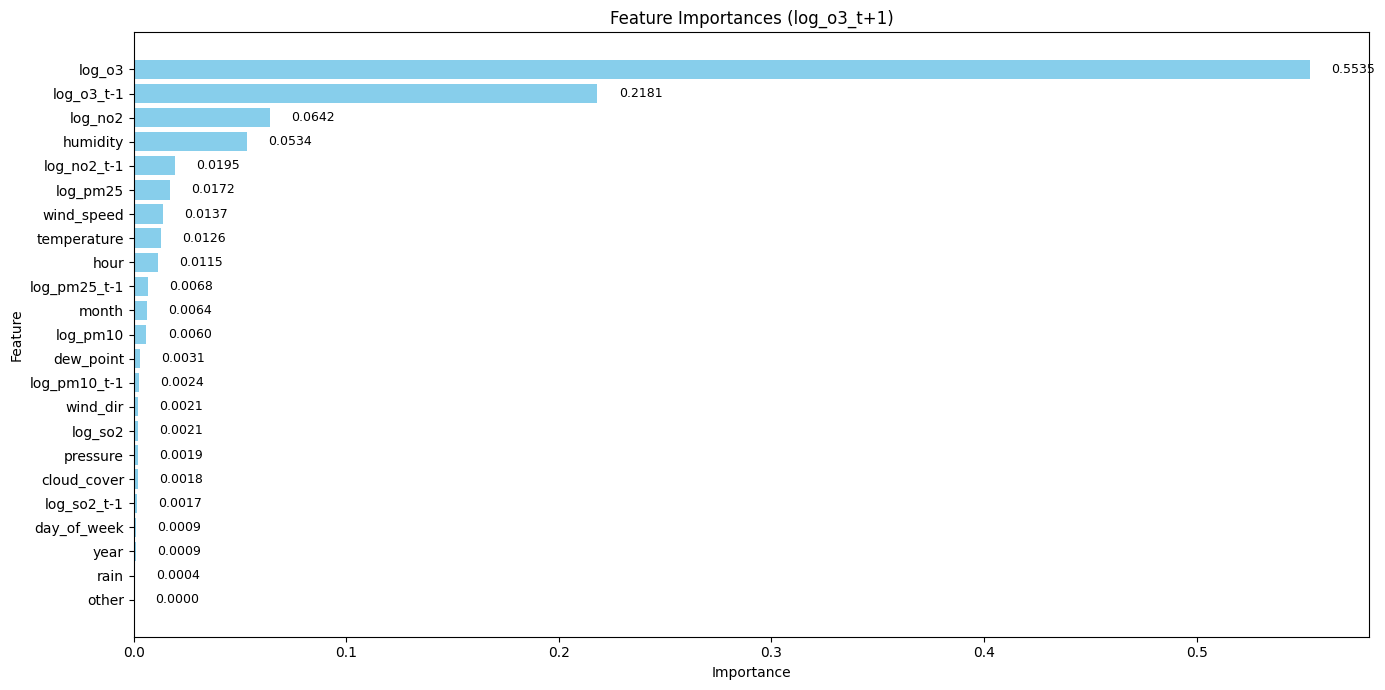

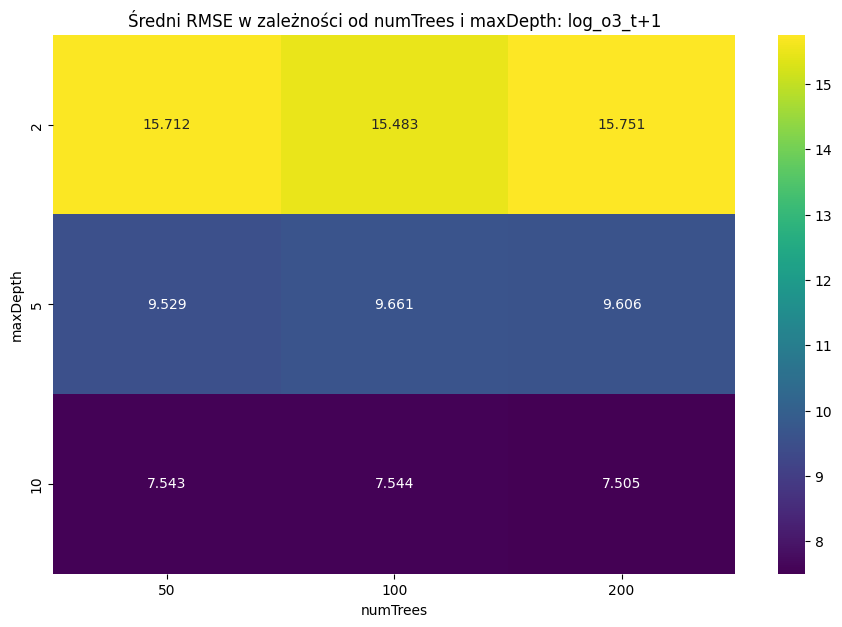

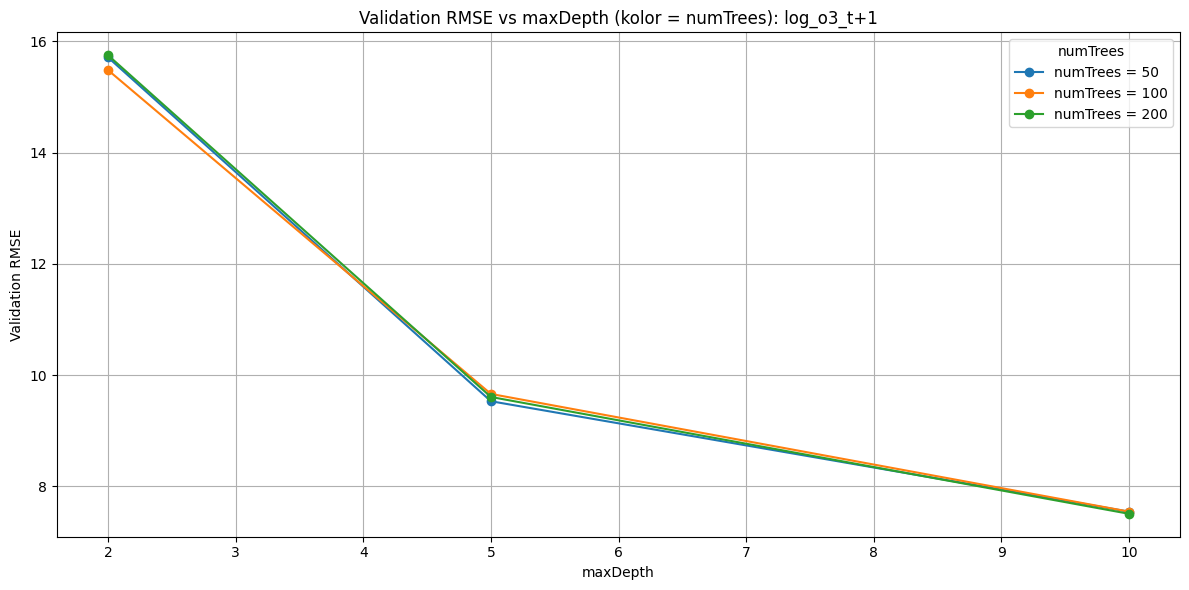

In [12]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "log_o3_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3_log"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    is_log=True,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=1.2698, R2=0.5470
 Fold 2: RMSE=1.2735, R2=0.5977
 Fold 3: RMSE=0.8394, R2=0.6389
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 1.1276
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.5945

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=1.0748, R2=0.6754
 Fold 2: RMSE=1.0409, R2=0.7312
 Fold 3: RMSE=0.7236, R2=0.7317
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 0.9464
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.7128

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:49:50 WARN DAGScheduler: Broadcasting large task binary with size 1090.2 KiB
25/05/31 08:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1950.8 KiB
25/05/31 08:49:52 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/05/31 08:49:53 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
25/05/31 08:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1234.3 KiB
                                                                                

 Fold 1: RMSE=1.0684, R2=0.6793


25/05/31 08:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1107.7 KiB
25/05/31 08:50:00 WARN DAGScheduler: Broadcasting large task binary with size 2017.3 KiB
25/05/31 08:50:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 08:50:03 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1503.7 KiB
                                                                                

 Fold 2: RMSE=1.0137, R2=0.7451


25/05/31 08:50:11 WARN DAGScheduler: Broadcasting large task binary with size 1124.0 KiB
25/05/31 08:50:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:50:13 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:50:15 WARN DAGScheduler: Broadcasting large task binary with size 1032.4 KiB
25/05/31 08:50:16 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 08:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1768.2 KiB
                                                                                

 Fold 3: RMSE=0.7136, R2=0.7390
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 0.9319
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.7211

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=1.2830, R2=0.5375
 Fold 2: RMSE=1.3010, R2=0.5801
 Fold 3: RMSE=0.8601, R2=0.6209
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 1.1480
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.5795

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=1.0907, R2=0.6657


 Fold 2: RMSE=1.0496, R2=0.7267


 Fold 3: RMSE=0.7226, R2=0.7324
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 0.9543
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.7083

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1108.3 KiB
25/05/31 08:50:50 WARN DAGScheduler: Broadcasting large task binary with size 2034.3 KiB
25/05/31 08:50:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 08:50:53 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 08:50:55 WARN DAGScheduler: Broadcasting large task binary with size 1591.3 KiB
25/05/31 08:50:56 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
25/05/31 08:50:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
                                                                                

 Fold 1: RMSE=1.0635, R2=0.6822


25/05/31 08:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1114.1 KiB
25/05/31 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:51:09 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
25/05/31 08:51:12 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 08:51:14 WARN DAGScheduler: Broadcasting large task binary with size 1841.2 KiB
25/05/31 08:51:16 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
25/05/31 08:51:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
                                                                                

 Fold 2: RMSE=1.0116, R2=0.7461


25/05/31 08:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1120.3 KiB
25/05/31 08:51:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:51:33 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1154.2 KiB
25/05/31 08:51:37 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:51:40 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:51:42 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
25/05/31 08:51:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 3: RMSE=0.7033, R2=0.7465
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 0.9261
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.7250

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=1.2841, R2=0.5367


 Fold 2: RMSE=1.3037, R2=0.5784


 Fold 3: RMSE=0.8711, R2=0.6111
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 1.1530
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.5754

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1099.9 KiB
                                                                                

 Fold 1: RMSE=1.0928, R2=0.6645


25/05/31 08:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
                                                                                

 Fold 2: RMSE=1.0518, R2=0.7256


25/05/31 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 3: RMSE=0.7265, R2=0.7295
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 0.9570
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.7065

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:52:36 WARN DAGScheduler: Broadcasting large task binary with size 1099.9 KiB
25/05/31 08:52:37 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:52:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
25/05/31 08:52:42 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 08:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1933.7 KiB
25/05/31 08:52:46 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/05/31 08:52:49 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/05/31 08:52:53 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
25/05/31 08:52:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
                                                                                

 Fold 1: RMSE=1.0712, R2=0.6776


25/05/31 08:53:12 WARN DAGScheduler: Broadcasting large task binary with size 1100.1 KiB
25/05/31 08:53:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:53:17 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
25/05/31 08:53:22 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:53:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
25/05/31 08:53:34 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 08:53:40 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
25/05/31 08:53:46 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:53:51 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
25/05/31 08:53:53 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=1.0106, R2=0.7466


25/05/31 08:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:54:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1209.1 KiB
25/05/31 08:54:18 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 08:54:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:54:27 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 08:54:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:54:41 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB
25/05/31 08:54:49 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 08:54:54 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
25/05/31 08:54:56 WARN DAGScheduler: Broadcast

 Fold 3: RMSE=0.7003, R2=0.7487
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 0.9274
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.7243
Najlepsze parametry: {'numTrees': 100, 'maxDepth': 10} z RMSE: 0.9261036391038079


25/05/31 08:55:09 WARN DAGScheduler: Broadcasting large task binary with size 1107.4 KiB
25/05/31 08:55:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:55:14 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:55:17 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
25/05/31 08:55:19 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:55:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:55:25 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
25/05/31 08:55:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 08:55:36 WARN TaskSetManager: Stage 16061 contains a task of very large size (6244 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2
Test set RMSE: 0.5843
Test set R2: 0.7664


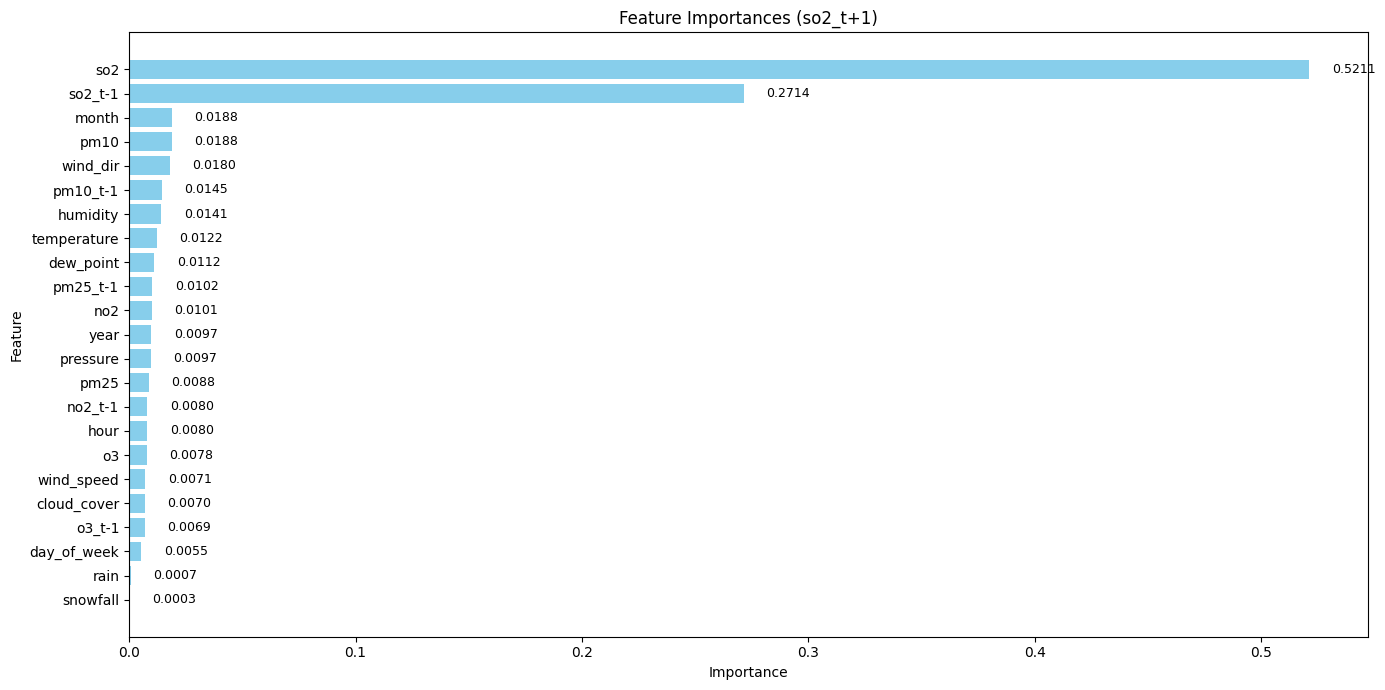

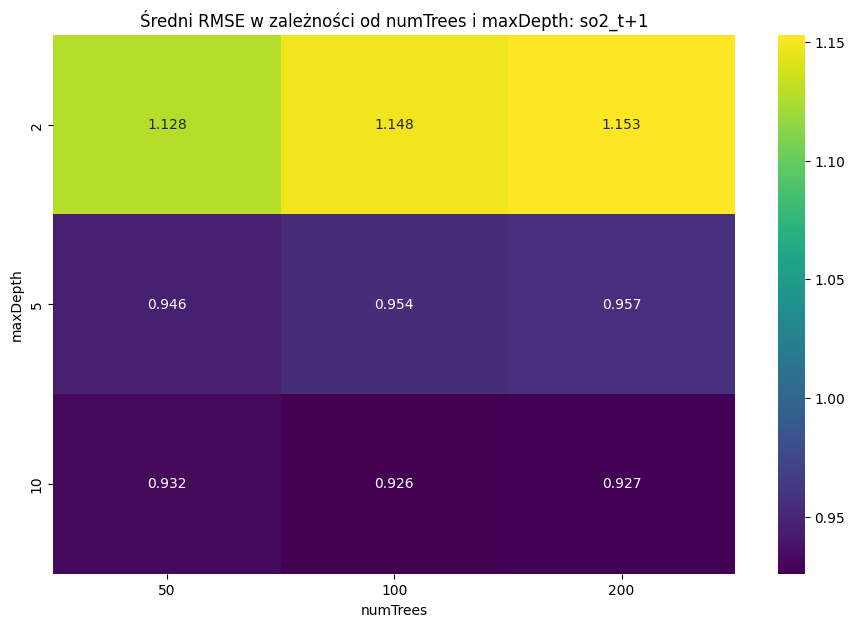

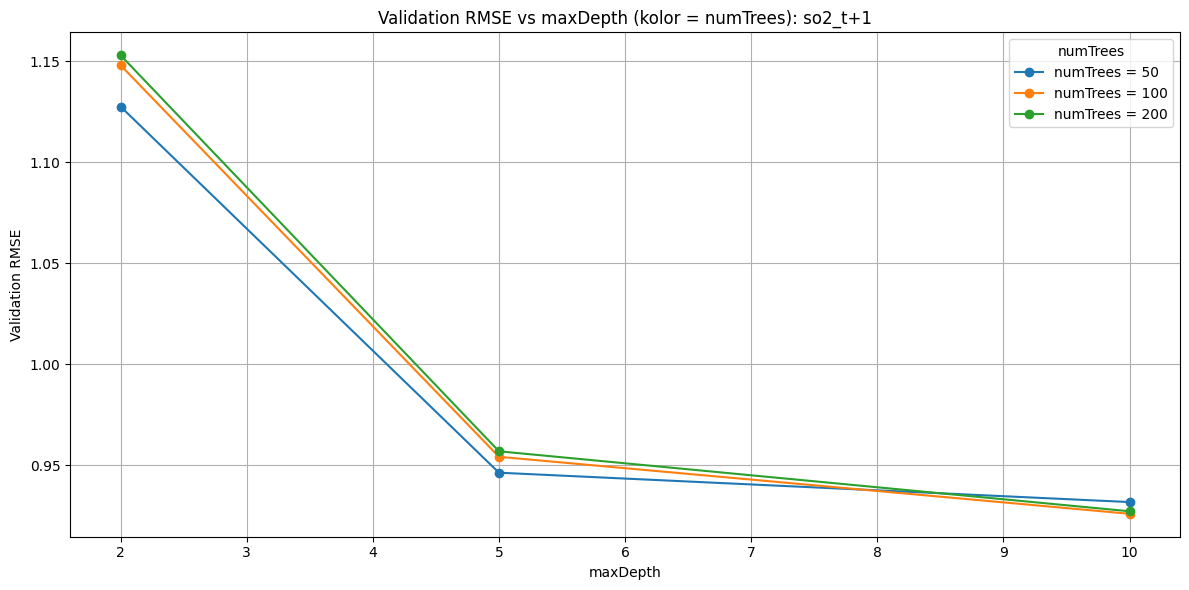

In [13]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "pm10", "pm25", "no2", "o3", "so2",
    "pm10_t-1", "pm25_t-1", "no2_t-1", "o3_t-1", "so2_t-1"
]

target_col = "so2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=1.3694, R2=0.4731
 Fold 2: RMSE=1.3402, R2=0.5544
 Fold 3: RMSE=0.8505, R2=0.6293
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 1.1867
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.5523

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=1.1768, R2=0.6109
 Fold 2: RMSE=1.0998, R2=0.7000
 Fold 3: RMSE=0.7224, R2=0.7325
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 0.9997
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.6811

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 08:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1116.7 KiB
25/05/31 08:56:07 WARN DAGScheduler: Broadcasting large task binary with size 2044.1 KiB
25/05/31 08:56:08 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 08:56:09 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
25/05/31 08:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB
                                                                                

 Fold 1: RMSE=1.1590, R2=0.6226


25/05/31 08:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1128.3 KiB
25/05/31 08:56:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:56:19 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 08:56:19 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
25/05/31 08:56:21 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 08:56:22 WARN DAGScheduler: Broadcasting large task binary with size 1712.0 KiB
                                                                                

 Fold 2: RMSE=1.0398, R2=0.7318


25/05/31 08:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1130.3 KiB
25/05/31 08:56:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:56:32 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:56:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.3 KiB
25/05/31 08:56:34 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 08:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1928.5 KiB
                                                                                

 Fold 3: RMSE=0.6911, R2=0.7552
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 0.9633
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.7032

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=1.3782, R2=0.4663
 Fold 2: RMSE=1.3536, R2=0.5455


 Fold 3: RMSE=0.8594, R2=0.6215
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 1.1970
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.5445

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=1.1885, R2=0.6031


 Fold 2: RMSE=1.1049, R2=0.6972


 Fold 3: RMSE=0.7260, R2=0.7299
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 1.0065
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.6767

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1120.0 KiB
25/05/31 08:57:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:57:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 08:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.5 KiB
25/05/31 08:57:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
25/05/31 08:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1803.4 KiB
25/05/31 08:57:19 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
25/05/31 08:57:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
                                                                                

 Fold 1: RMSE=1.1455, R2=0.6313


25/05/31 08:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1121.4 KiB
25/05/31 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:57:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1165.6 KiB
25/05/31 08:57:37 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 08:57:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 08:57:42 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
25/05/31 08:57:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
                                                                                

 Fold 2: RMSE=1.0330, R2=0.7353


25/05/31 08:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1121.4 KiB
25/05/31 08:57:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB
25/05/31 08:58:04 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 08:58:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
25/05/31 08:58:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=0.6936, R2=0.7535
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 0.9574
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.7067

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=1.3876, R2=0.4590


 Fold 2: RMSE=1.3580, R2=0.5425


 Fold 3: RMSE=0.8633, R2=0.6181
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 1.2029
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.5399

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 08:58:39 WARN DAGScheduler: Broadcasting large task binary with size 1102.6 KiB
                                                                                

 Fold 1: RMSE=1.1861, R2=0.6047


25/05/31 08:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
                                                                                

 Fold 2: RMSE=1.1016, R2=0.6989


25/05/31 08:58:59 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
                                                                                

 Fold 3: RMSE=0.7277, R2=0.7286
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 1.0051
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.6774

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 08:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1102.6 KiB
25/05/31 08:59:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:59:11 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1183.0 KiB
25/05/31 08:59:14 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 08:59:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:59:19 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
25/05/31 08:59:22 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 08:59:26 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
25/05/31 08:59:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 08:59:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                              

 Fold 1: RMSE=1.1294, R2=0.6416


25/05/31 08:59:47 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
25/05/31 08:59:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 08:59:52 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 08:59:55 WARN DAGScheduler: Broadcasting large task binary with size 1222.3 KiB
25/05/31 08:59:56 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:00:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:00:03 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
25/05/31 09:00:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 09:00:15 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
25/05/31 09:00:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:00:27 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
25/05/31 09:00:29 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=1.0305, R2=0.7366


25/05/31 09:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
25/05/31 09:00:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:00:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1234.0 KiB
25/05/31 09:00:56 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:01:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:01:05 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 09:01:19 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 09:01:27 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:01:33 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
25/05/31 09:01:36 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=0.6931, R2=0.7538
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 0.9510
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.7107
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 0.9509753905677291


25/05/31 09:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1088.9 KiB
25/05/31 09:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:02:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:02:09 WARN DAGScheduler: Broadcasting large task binary with size 1237.8 KiB
25/05/31 09:02:10 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 09:02:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 09:02:21 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 09:02:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 09:02:38 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
25/05/31 09:02:46 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:02:51 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
25/05/31 09:02:55 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2_log


Test set RMSE: 0.5559
Test set R2: 0.7885


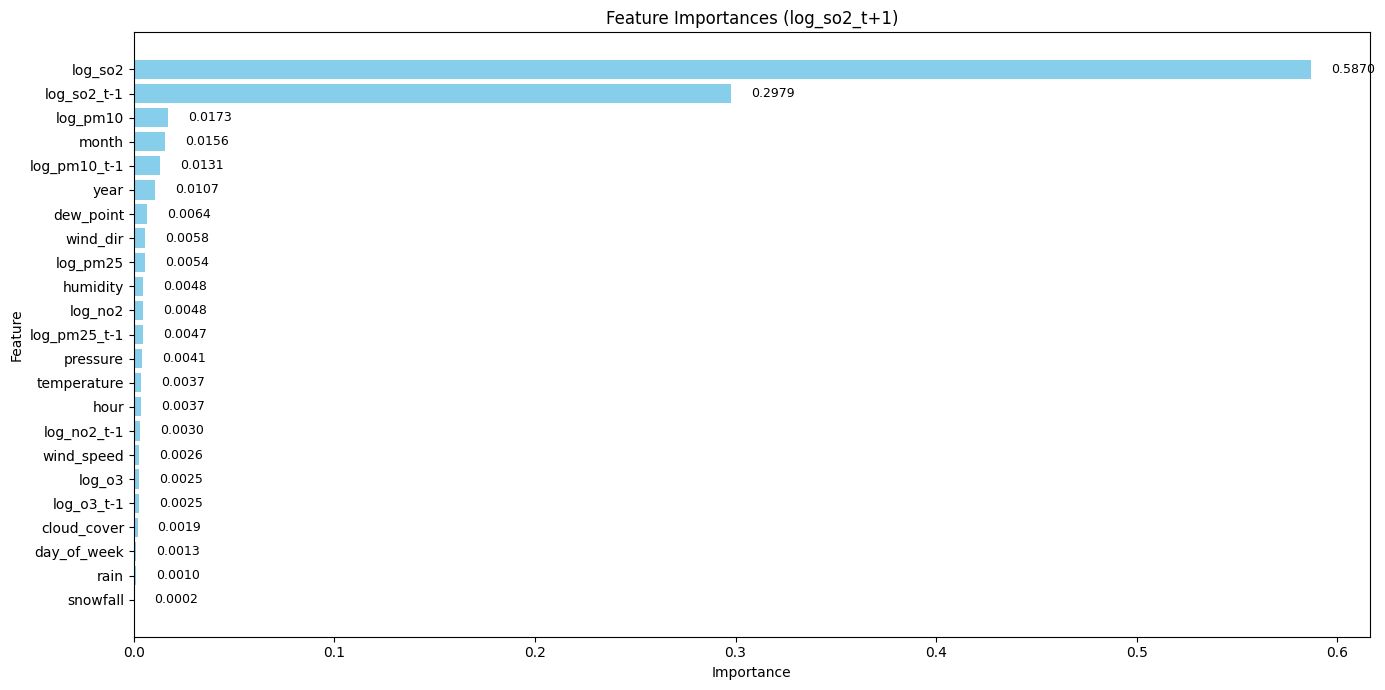

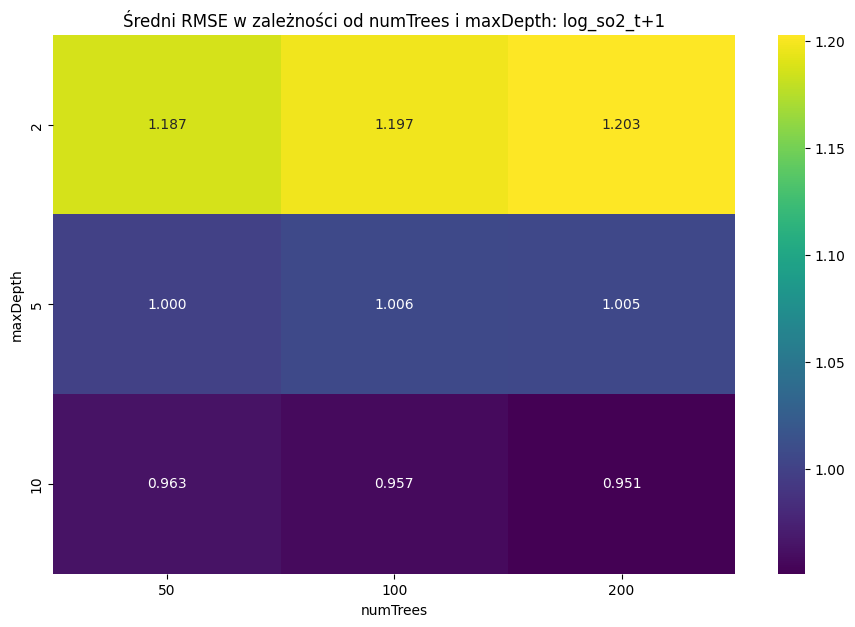

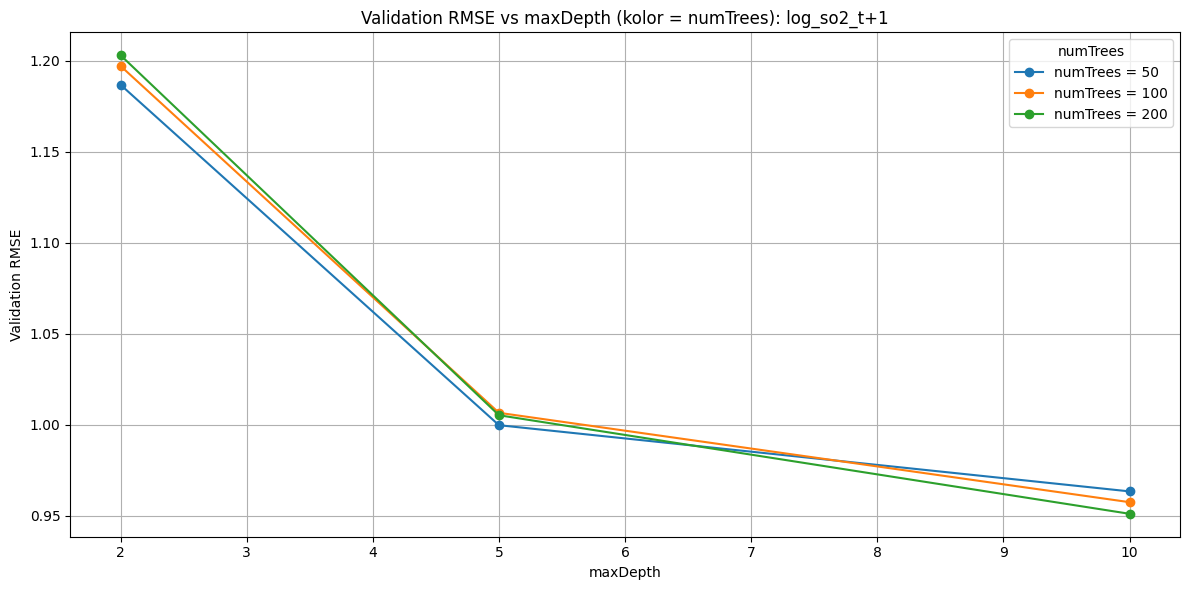

In [14]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "log_so2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2_log"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    is_log=True,
    model_save_path=model_save_path
)

In [15]:
# best_params, model = timeseries_cv_rf(
#     df_to_cv=df,
#     datetime_col="datetime_utc",
#     feature_cols=feature_cols,
#     target_col=target_col,
#     param_grid=param_grid,
#     folds=3
# )


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=9.0295, R2=0.7045
 Fold 2: RMSE=8.9761, R2=0.6984
 Fold 3: RMSE=5.3959, R2=0.7964
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 7.8005
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.7331

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=6.6862, R2=0.8379
 Fold 2: RMSE=7.0091, R2=0.8161
 Fold 3: RMSE=4.3059, R2=0.8703
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 6.0004
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.8415

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 09:16:41 WARN DAGScheduler: Broadcasting large task binary with size 1097.7 KiB
25/05/31 09:16:41 WARN DAGScheduler: Broadcasting large task binary with size 1996.4 KiB
25/05/31 09:16:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 09:16:44 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
25/05/31 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1423.1 KiB
                                                                                

 Fold 1: RMSE=6.4185, R2=0.8507


25/05/31 09:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
25/05/31 09:16:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:16:53 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 09:16:56 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 09:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1588.0 KiB
                                                                                

 Fold 2: RMSE=6.4902, R2=0.8423


25/05/31 09:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
25/05/31 09:17:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:17:07 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
25/05/31 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 09:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1773.3 KiB
                                                                                

 Fold 3: RMSE=4.0481, R2=0.8854
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.6523
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8595

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=9.0313, R2=0.7043
 Fold 2: RMSE=8.9694, R2=0.6988


 Fold 3: RMSE=5.4073, R2=0.7955
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 7.8027
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.7329

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=6.6260, R2=0.8408


 Fold 2: RMSE=6.9321, R2=0.8201


 Fold 3: RMSE=4.2595, R2=0.8731
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 5.9392
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.8447

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 09:17:47 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
25/05/31 09:17:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1033.8 KiB
25/05/31 09:17:52 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
25/05/31 09:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1756.6 KiB
25/05/31 09:17:55 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
25/05/31 09:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
                                                                                

 Fold 1: RMSE=6.2909, R2=0.8565


25/05/31 09:18:06 WARN DAGScheduler: Broadcasting large task binary with size 1118.0 KiB
25/05/31 09:18:08 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:18:10 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1106.9 KiB
25/05/31 09:18:13 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 09:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1934.8 KiB
25/05/31 09:18:17 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/05/31 09:18:21 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
                                                                                

 Fold 2: RMSE=6.4502, R2=0.8442


25/05/31 09:18:32 WARN DAGScheduler: Broadcasting large task binary with size 1119.4 KiB
25/05/31 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:18:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:18:39 WARN DAGScheduler: Broadcasting large task binary with size 1150.9 KiB
25/05/31 09:18:41 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:18:47 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
25/05/31 09:18:52 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 3: RMSE=4.0050, R2=0.8878
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.5820
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8629

Testuję parametry: numTrees=200, maxDepth=2


 Fold 1: RMSE=8.9831, R2=0.7075


 Fold 2: RMSE=8.8530, R2=0.7066


 Fold 3: RMSE=5.3777, R2=0.7978
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 7.7379
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.7373

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 09:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
                                                                                

 Fold 1: RMSE=6.6505, R2=0.8397


25/05/31 09:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
                                                                                

 Fold 2: RMSE=6.9287, R2=0.8203


25/05/31 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 3: RMSE=4.2726, R2=0.8723
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 5.9506
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.8441

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 09:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
25/05/31 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1153.4 KiB
25/05/31 09:19:53 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:19:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
25/05/31 09:20:01 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
25/05/31 09:20:06 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
25/05/31 09:20:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
[Stage 19389:>                                

 Fold 1: RMSE=6.3296, R2=0.8548


25/05/31 09:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
25/05/31 09:20:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:20:31 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1191.2 KiB
25/05/31 09:20:36 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 09:20:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:20:42 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
25/05/31 09:20:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 09:20:54 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
25/05/31 09:21:00 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:21:05 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 09:21:06 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=6.4201, R2=0.8457


25/05/31 09:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 09:21:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1207.4 KiB
25/05/31 09:21:32 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:21:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:21:41 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
25/05/31 09:21:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:21:55 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
25/05/31 09:22:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:22:08 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 09:22:10 WARN DAGScheduler: Broadcast

 Fold 3: RMSE=3.9835, R2=0.8890
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.5778
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8632
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.577753423081352


25/05/31 09:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
25/05/31 09:22:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:22:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1214.7 KiB
25/05/31 09:22:41 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:22:48 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:22:51 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
25/05/31 09:23:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/31 09:23:09 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 09:23:18 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:23:23 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/31 09:23:27 WARN DAGScheduler: Broadcast

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10_log_only_f


Test set RMSE: 6.1848
Test set R2: 0.8752


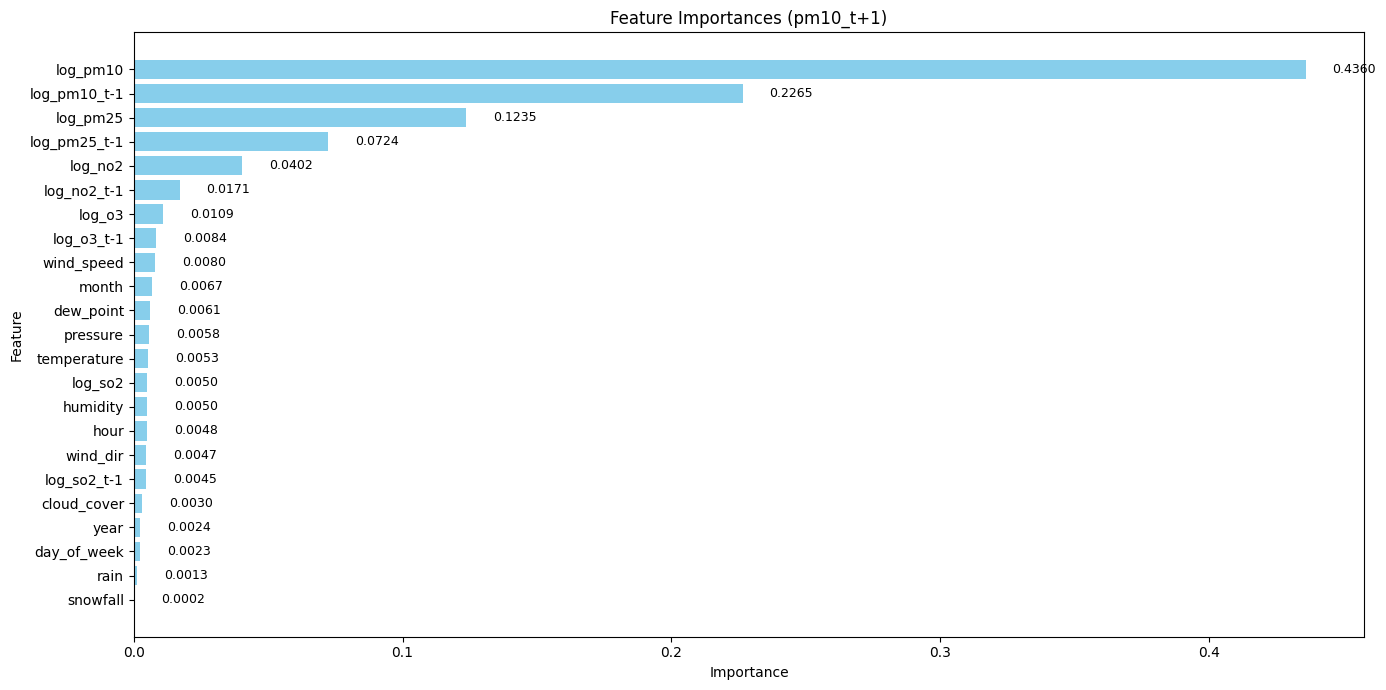

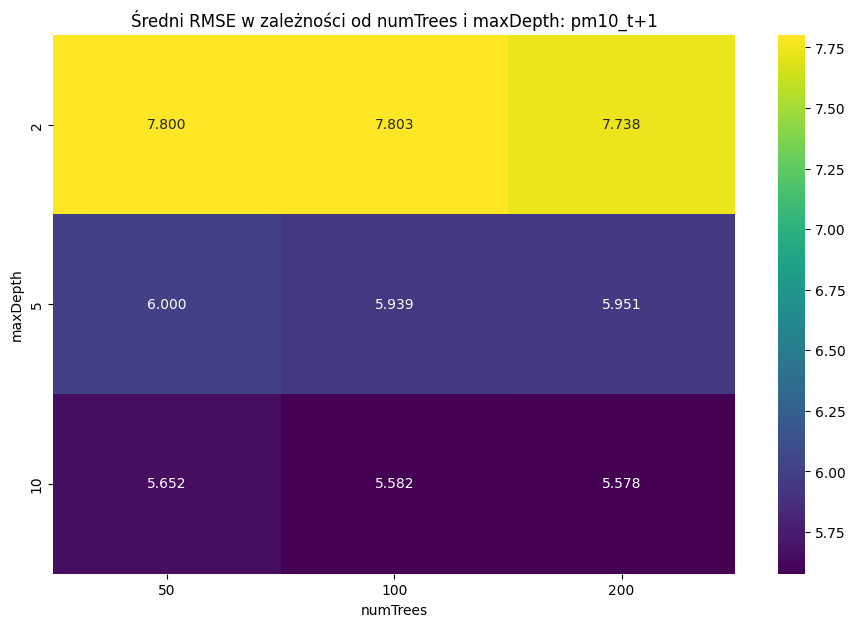

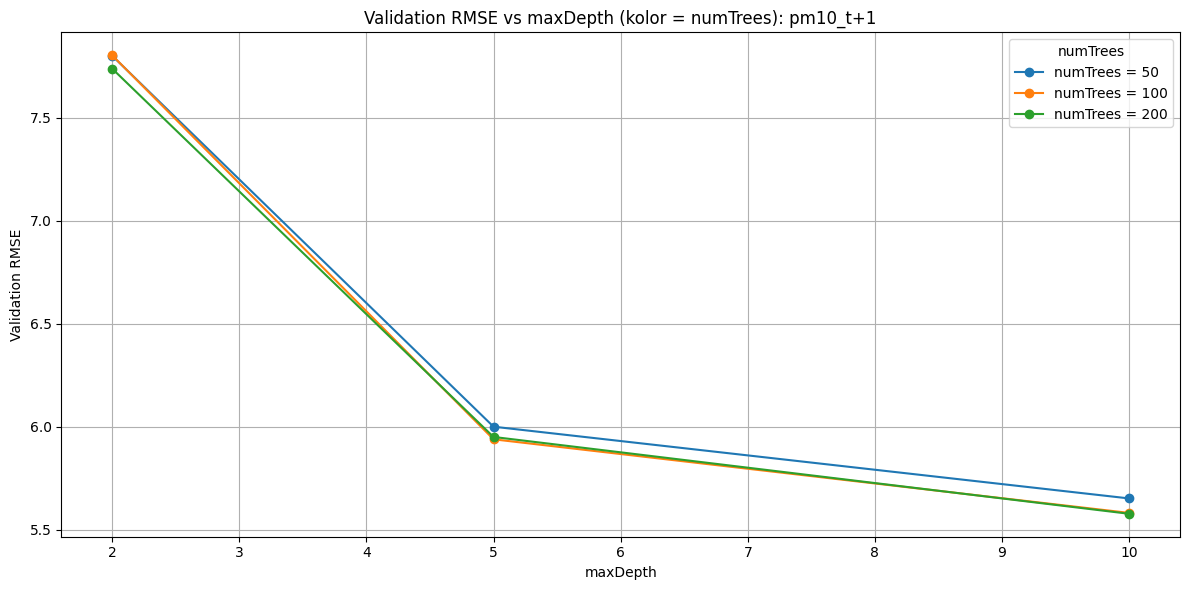

In [16]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "pm10_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm10_log_only_f"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=6.3086, R2=0.7799
 Fold 2: RMSE=4.3680, R2=0.8309
 Fold 3: RMSE=3.9163, R2=0.8528
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 4.8643
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.8212

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=4.1052, R2=0.9068
 Fold 2: RMSE=3.1065, R2=0.9145
 Fold 3: RMSE=3.0365, R2=0.9115
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 3.4161
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.9109

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 09:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB
25/05/31 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 09:24:07 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
25/05/31 09:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1557.4 KiB
                                                                                

 Fold 1: RMSE=3.7155, R2=0.9237


25/05/31 09:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1126.2 KiB
25/05/31 09:24:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:24:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
25/05/31 09:24:19 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1769.3 KiB
                                                                                

 Fold 2: RMSE=2.8177, R2=0.9296


25/05/31 09:24:28 WARN DAGScheduler: Broadcasting large task binary with size 1126.8 KiB
25/05/31 09:24:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:24:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
25/05/31 09:24:33 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 09:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1971.8 KiB
                                                                                

 Fold 3: RMSE=2.8541, R2=0.9218
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 3.1291
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9250

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=6.3386, R2=0.7778


 Fold 2: RMSE=4.3464, R2=0.8326


 Fold 3: RMSE=3.9332, R2=0.8515
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 4.8728
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.8206

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=3.9664, R2=0.9130


 Fold 2: RMSE=3.0653, R2=0.9167


 Fold 3: RMSE=3.0445, R2=0.9110
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 3.3587
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.9136

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1116.7 KiB
25/05/31 09:25:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:25:14 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
25/05/31 09:25:16 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 09:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1914.0 KiB
25/05/31 09:25:20 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
25/05/31 09:25:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

 Fold 1: RMSE=3.5898, R2=0.9287


25/05/31 09:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1119.5 KiB
25/05/31 09:25:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:25:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1158.8 KiB
25/05/31 09:25:39 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:25:44 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
25/05/31 09:25:48 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=2.7852, R2=0.9313


25/05/31 09:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1119.7 KiB
25/05/31 09:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1189.3 KiB
25/05/31 09:26:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 09:26:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:26:15 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 09:26:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=2.8212, R2=0.9236
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 3.0654
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9279

Testuję parametry: numTrees=200, maxDepth=2


 Fold 1: RMSE=6.3219, R2=0.7790


 Fold 2: RMSE=4.3088, R2=0.8355


 Fold 3: RMSE=3.8602, R2=0.8570
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 4.8303
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.8238

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
                                                                                

 Fold 1: RMSE=3.9612, R2=0.9132


25/05/31 09:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
                                                                                

 Fold 2: RMSE=3.0558, R2=0.9173


25/05/31 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
                                                                                

 Fold 3: RMSE=3.0563, R2=0.9103
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 3.3577
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.9136

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 09:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1101.3 KiB
25/05/31 09:27:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:27:20 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
25/05/31 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 09:27:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:27:28 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
25/05/31 09:27:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
25/05/31 09:27:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:27:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
25/05/31 09:27:48 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=3.6026, R2=0.9282


25/05/31 09:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
25/05/31 09:28:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:28:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1209.4 KiB
25/05/31 09:28:08 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:28:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:28:16 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:28:27 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/05/31 09:28:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:28:39 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
25/05/31 09:28:41 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=2.7774, R2=0.9316


25/05/31 09:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
25/05/31 09:28:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:29:02 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1224.9 KiB
25/05/31 09:29:08 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
25/05/31 09:29:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
25/05/31 09:29:41 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:29:47 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
25/05/31 09:29:50 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=2.8324, R2=0.9230
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 3.0708
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9276
Najlepsze parametry: {'numTrees': 100, 'maxDepth': 10} z RMSE: 3.065402869059993


25/05/31 09:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1107.1 KiB
25/05/31 09:30:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:30:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1202.5 KiB
25/05/31 09:30:13 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:30:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:30:20 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
25/05/31 09:30:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:30:32 WARN TaskSetManager: Stage 21418 contains a task of very large size (6670 KiB). The maximum recommended task size is 1000 KiB.


Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25_log_only_f
Test set RMSE: 3.4435
Test set R2: 0.9334


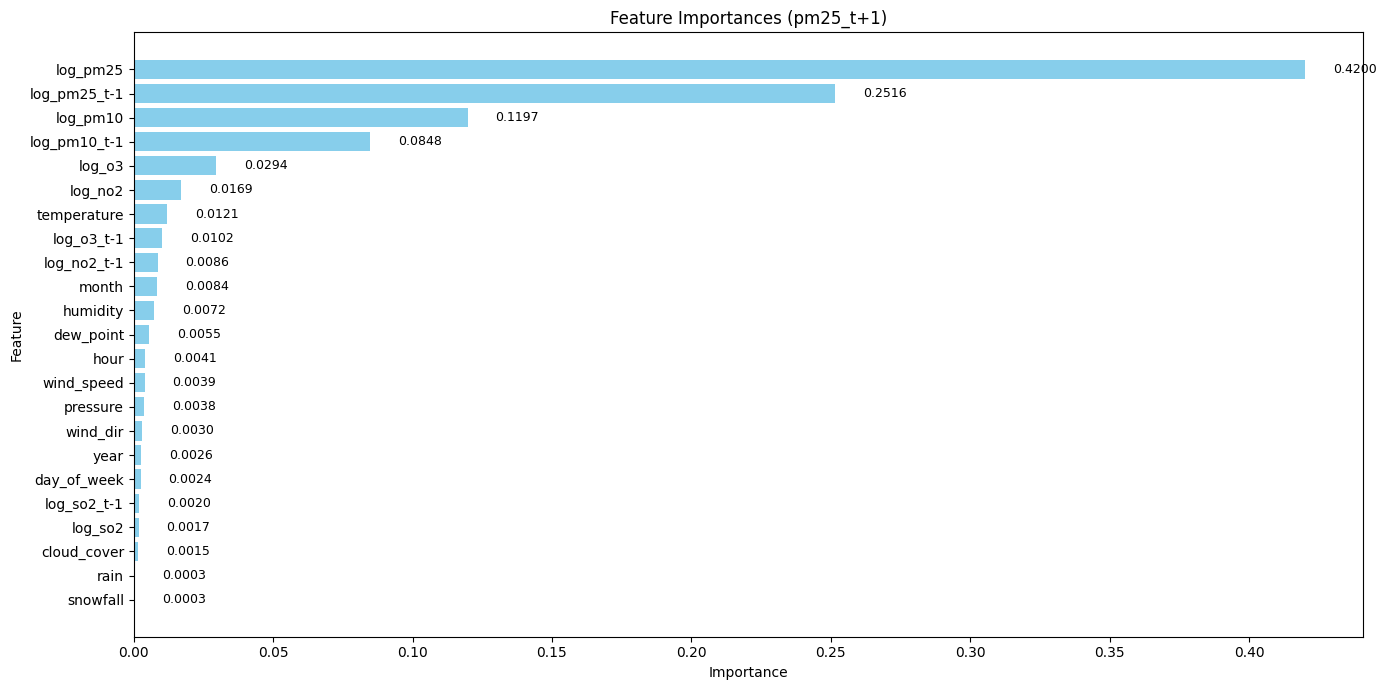

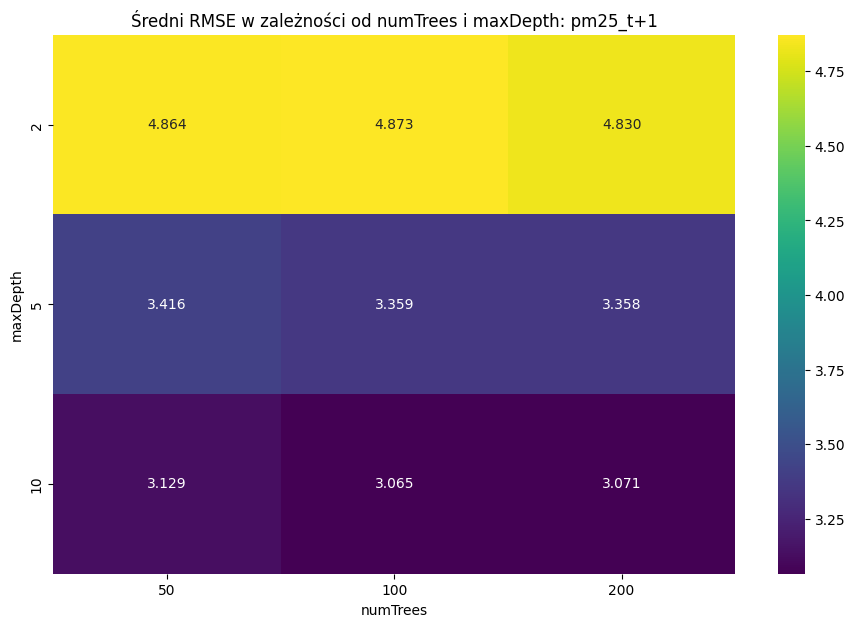

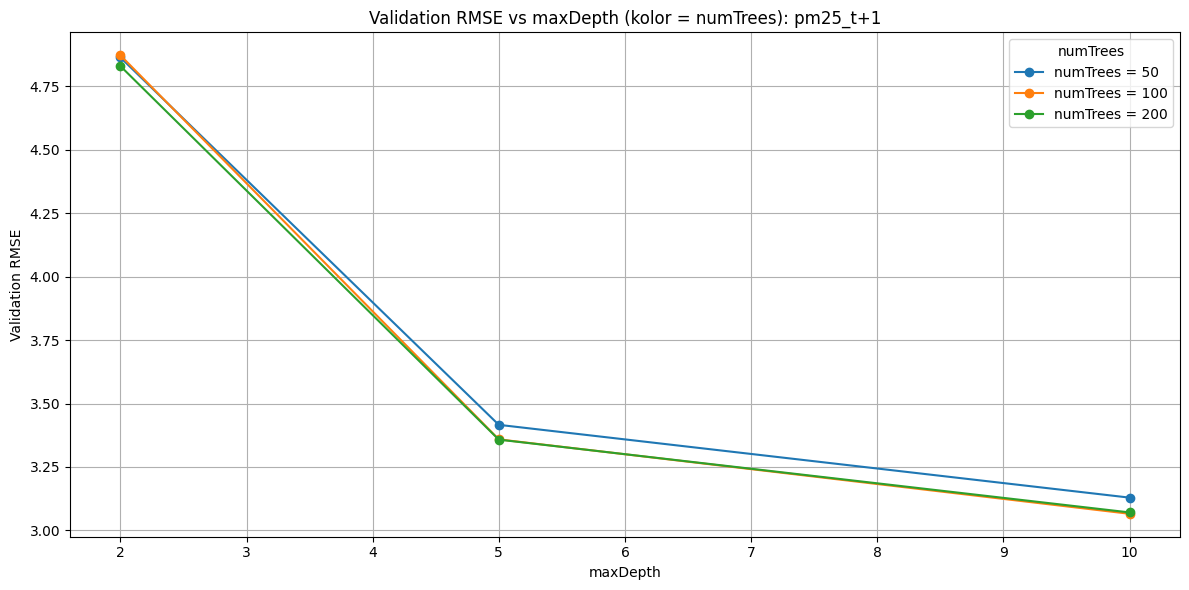

In [17]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "pm25_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_pm25_log_only_f"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=9.3675, R2=0.5913
 Fold 2: RMSE=10.0471, R2=0.5918
 Fold 3: RMSE=8.4490, R2=0.6289
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 9.2879
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.6040

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=6.8809, R2=0.7795
 Fold 2: RMSE=7.1081, R2=0.7957
 Fold 3: RMSE=6.0749, R2=0.8082
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 6.6879
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.7944

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
25/05/31 09:31:04 WARN DAGScheduler: Broadcasting large task binary with size 2019.2 KiB
25/05/31 09:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 09:31:07 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 09:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1470.2 KiB
                                                                                

 Fold 1: RMSE=5.9947, R2=0.8326


25/05/31 09:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1127.8 KiB
25/05/31 09:31:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:31:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1058.1 KiB
25/05/31 09:31:18 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 09:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
                                                                                

 Fold 2: RMSE=5.8193, R2=0.8630


25/05/31 09:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1129.1 KiB
25/05/31 09:31:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:31:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:31:31 WARN DAGScheduler: Broadcasting large task binary with size 1104.1 KiB
25/05/31 09:31:33 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 09:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1947.2 KiB
                                                                                

 Fold 3: RMSE=5.0642, R2=0.8667
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 5.6260
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.8541

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=9.2677, R2=0.6000
 Fold 2: RMSE=9.9771, R2=0.5974


 Fold 3: RMSE=8.2908, R2=0.6427
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 9.1785
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.6134

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=6.8466, R2=0.7817


 Fold 2: RMSE=7.1098, R2=0.7956


 Fold 3: RMSE=6.0421, R2=0.8102
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 6.6662
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.7958

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 09:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1116.1 KiB
25/05/31 09:32:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:32:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1087.5 KiB
25/05/31 09:32:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
25/05/31 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1883.5 KiB
25/05/31 09:32:20 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
25/05/31 09:32:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

 Fold 1: RMSE=5.9294, R2=0.8363


25/05/31 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1121.3 KiB
25/05/31 09:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:32:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1165.8 KiB
25/05/31 09:32:38 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 09:32:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:32:43 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
25/05/31 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 2: RMSE=5.8303, R2=0.8625


25/05/31 09:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
25/05/31 09:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:33:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1189.5 KiB
25/05/31 09:33:06 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 09:33:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:33:12 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
25/05/31 09:33:18 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
                                                                                

 Fold 3: RMSE=5.0265, R2=0.8687
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 5.5954
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.8558

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=9.1702, R2=0.6084


 Fold 2: RMSE=9.8522, R2=0.6074


 Fold 3: RMSE=8.1988, R2=0.6506
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 9.0737
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.6221

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 09:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
                                                                                

 Fold 1: RMSE=6.8218, R2=0.7833


25/05/31 09:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1102.3 KiB
                                                                                

 Fold 2: RMSE=7.0683, R2=0.7979


25/05/31 09:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
                                                                                

 Fold 3: RMSE=5.9945, R2=0.8132
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 6.6282
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.7981

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 09:34:12 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
25/05/31 09:34:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:34:16 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1168.3 KiB
25/05/31 09:34:19 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 09:34:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:34:24 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
25/05/31 09:34:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 09:34:33 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB
25/05/31 09:34:37 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:34:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 09:34:43 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=5.9418, R2=0.8356


25/05/31 09:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1102.3 KiB
25/05/31 09:34:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:34:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
25/05/31 09:35:03 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:35:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:35:11 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
25/05/31 09:35:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 09:35:23 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
25/05/31 09:35:29 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:35:34 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
25/05/31 09:35:36 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=5.8167, R2=0.8632


25/05/31 09:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
25/05/31 09:35:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:35:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1224.5 KiB
25/05/31 09:36:03 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:36:10 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:36:13 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
25/05/31 09:36:23 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 09:36:28 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
25/05/31 09:36:36 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:36:41 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
25/05/31 09:36:44 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=5.0042, R2=0.8698
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 5.5876
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.8562
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 5.587557564716019


25/05/31 09:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1088.9 KiB
25/05/31 09:37:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:37:10 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1232.7 KiB
25/05/31 09:37:17 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:37:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:37:28 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
25/05/31 09:37:40 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
25/05/31 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/05/31 09:37:54 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:37:59 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
25/05/31 09:38:03 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2_log_only_f


Test set RMSE: 5.5103
Test set R2: 0.8674


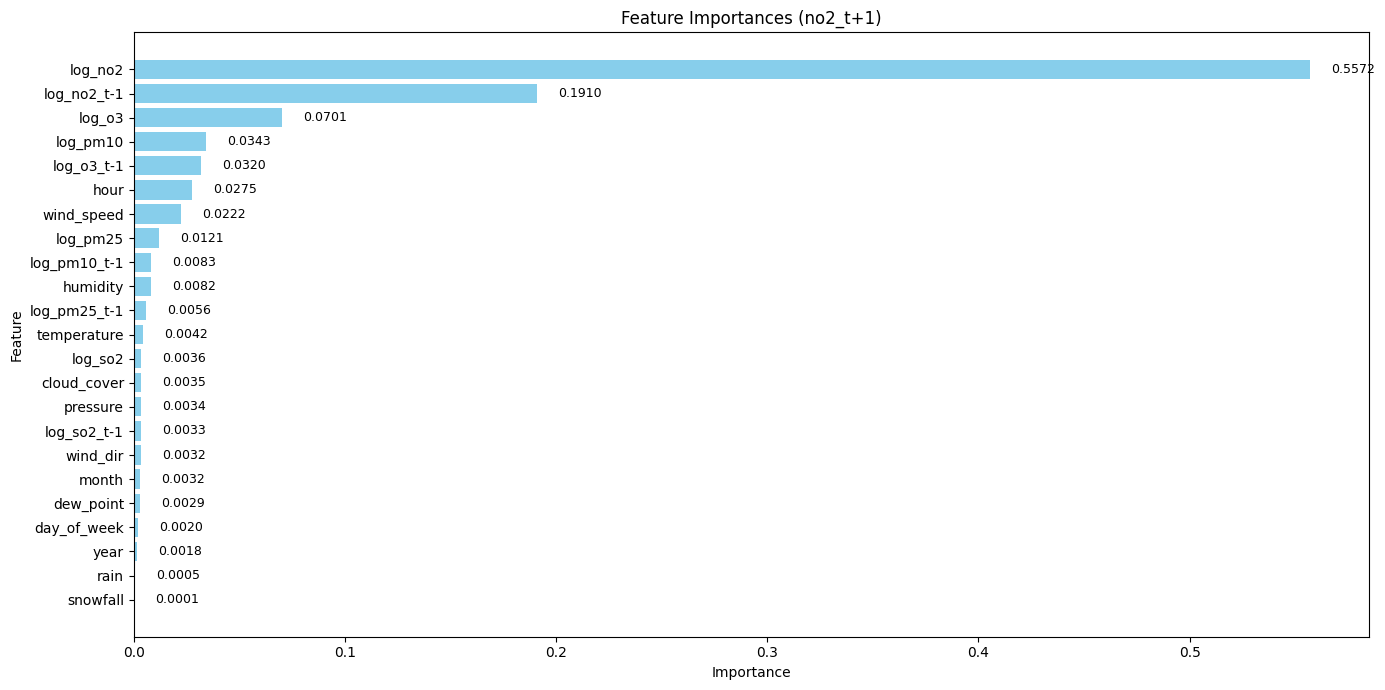

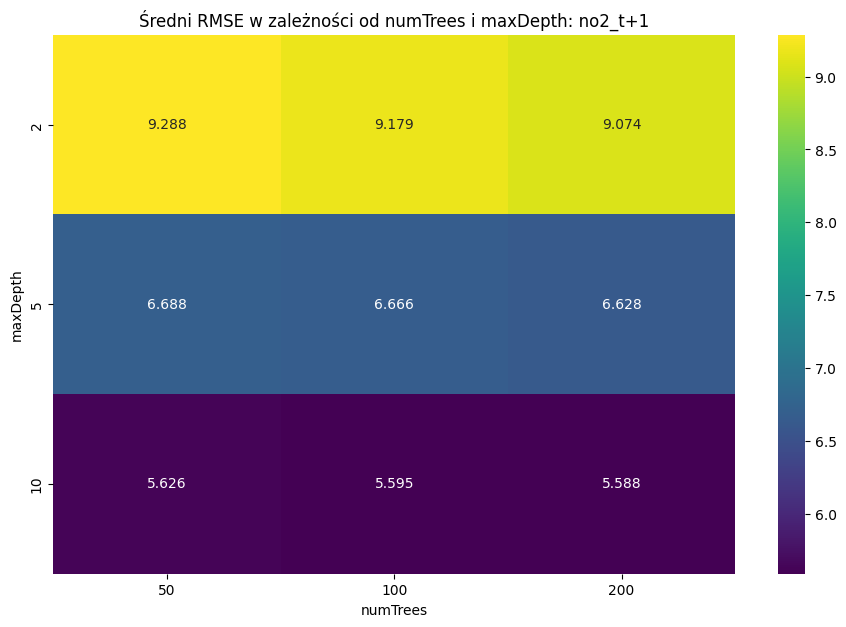

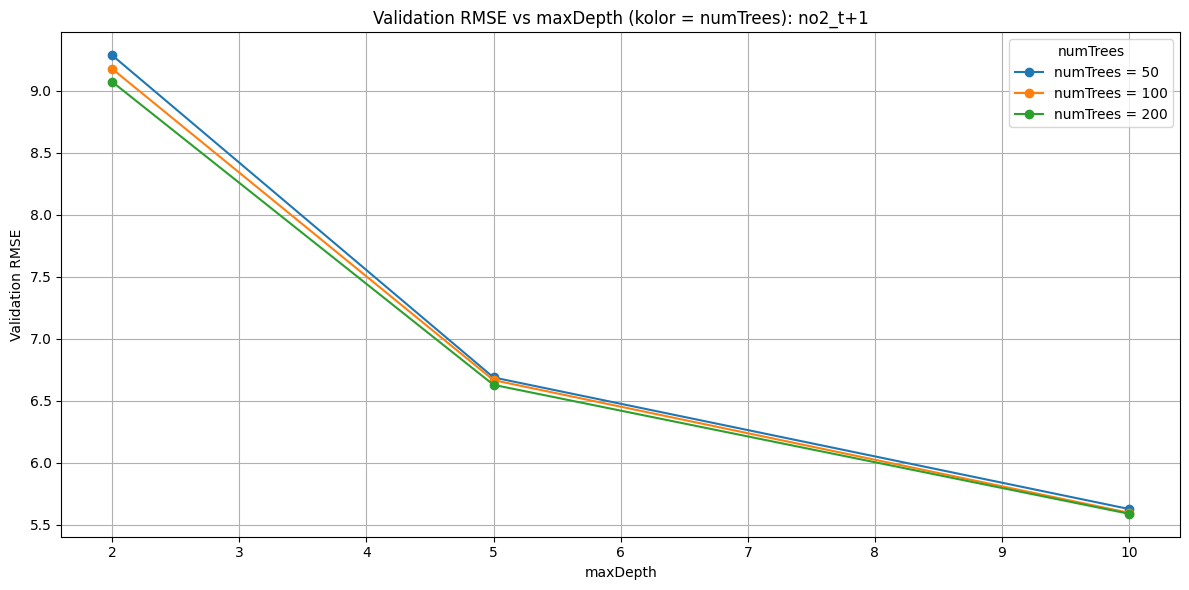

In [18]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "no2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_no2_log_only_f"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=13.4033, R2=0.8134
 Fold 2: RMSE=12.6555, R2=0.8001
 Fold 3: RMSE=11.8768, R2=0.8224
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 12.6452
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.8120

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=9.4835, R2=0.9066
 Fold 2: RMSE=9.1164, R2=0.8963
 Fold 3: RMSE=8.2879, R2=0.9135
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 8.9626
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.9055

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 09:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
25/05/31 09:38:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:38:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 09:38:44 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 09:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1564.4 KiB
                                                                                

 Fold 1: RMSE=7.9078, R2=0.9351


25/05/31 09:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1128.1 KiB
25/05/31 09:38:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:38:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1103.6 KiB
25/05/31 09:38:56 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/05/31 09:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1896.5 KiB
                                                                                

 Fold 2: RMSE=7.2878, R2=0.9337


25/05/31 09:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1130.8 KiB
25/05/31 09:39:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:39:07 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1151.5 KiB
25/05/31 09:39:10 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
25/05/31 09:39:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
                                                                                

 Fold 3: RMSE=6.7449, R2=0.9427
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 7.3135
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.9372

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=13.4710, R2=0.8115
 Fold 2: RMSE=12.8503, R2=0.7939


 Fold 3: RMSE=12.1330, R2=0.8147
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 12.8181
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.8067

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=9.5067, R2=0.9061


 Fold 2: RMSE=9.1488, R2=0.8955


 Fold 3: RMSE=8.3674, R2=0.9119
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 9.0076
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.9045

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 09:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1120.0 KiB
25/05/31 09:39:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:39:51 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1131.1 KiB
25/05/31 09:39:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
25/05/31 09:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1965.1 KiB
25/05/31 09:39:57 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
25/05/31 09:39:59 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
                                                                                

 Fold 1: RMSE=7.8690, R2=0.9357


25/05/31 09:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1119.9 KiB
25/05/31 09:40:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:40:13 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1190.3 KiB
25/05/31 09:40:16 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 09:40:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:40:21 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
25/05/31 09:40:25 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
                                                                                

 Fold 2: RMSE=7.2423, R2=0.9345


25/05/31 09:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1119.7 KiB
25/05/31 09:40:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:40:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 09:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1215.2 KiB
25/05/31 09:40:46 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:40:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:40:52 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 09:40:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
                                                                                

 Fold 3: RMSE=6.7278, R2=0.9430
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 7.2797
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.9378

Testuję parametry: numTrees=200, maxDepth=2
 Fold 1: RMSE=13.7150, R2=0.8047


 Fold 2: RMSE=13.0386, R2=0.7878


 Fold 3: RMSE=12.3283, R2=0.8087
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 13.0273
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.8004

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 09:41:23 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
                                                                                

 Fold 1: RMSE=9.4746, R2=0.9068


25/05/31 09:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
                                                                                

 Fold 2: RMSE=9.0804, R2=0.8971


25/05/31 09:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
                                                                                

 Fold 3: RMSE=8.2863, R2=0.9136
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 8.9471
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.9058

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 09:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1101.7 KiB
25/05/31 09:41:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:41:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
25/05/31 09:42:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
25/05/31 09:42:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:42:06 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
25/05/31 09:42:10 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:42:15 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
25/05/31 09:42:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:42:24 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
25/05/31 09:42:25 WARN DAGScheduler: Broadcast

 Fold 1: RMSE=7.8428, R2=0.9361


25/05/31 09:42:36 WARN DAGScheduler: Broadcasting large task binary with size 1101.4 KiB
25/05/31 09:42:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:42:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:42:45 WARN DAGScheduler: Broadcasting large task binary with size 1233.8 KiB
25/05/31 09:42:46 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/05/31 09:42:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/05/31 09:42:54 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
25/05/31 09:43:02 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
25/05/31 09:43:08 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
25/05/31 09:43:14 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:43:20 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
25/05/31 09:43:22 WARN DAGScheduler: Broadcas

 Fold 2: RMSE=7.2138, R2=0.9351


25/05/31 09:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1100.9 KiB
25/05/31 09:43:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:43:44 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
25/05/31 09:43:49 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 09:43:56 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 09:43:59 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 09:44:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 09:44:15 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
25/05/31 09:44:22 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:44:28 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
25/05/31 09:44:31 WARN DAGScheduler: Broadcas

 Fold 3: RMSE=6.7055, R2=0.9434
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 7.2540
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.9382
Najlepsze parametry: {'numTrees': 200, 'maxDepth': 10} z RMSE: 7.254024177744384


25/05/31 09:44:49 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
25/05/31 09:44:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:44:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1238.5 KiB
25/05/31 09:45:06 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
25/05/31 09:45:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/05/31 09:45:17 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
25/05/31 09:45:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/05/31 09:45:36 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
25/05/31 09:45:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:45:50 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
25/05/31 09:45:56 WARN DAGScheduler: Broadcas

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3_log_only_f


Test set RMSE: 6.9321
Test set R2: 0.9451


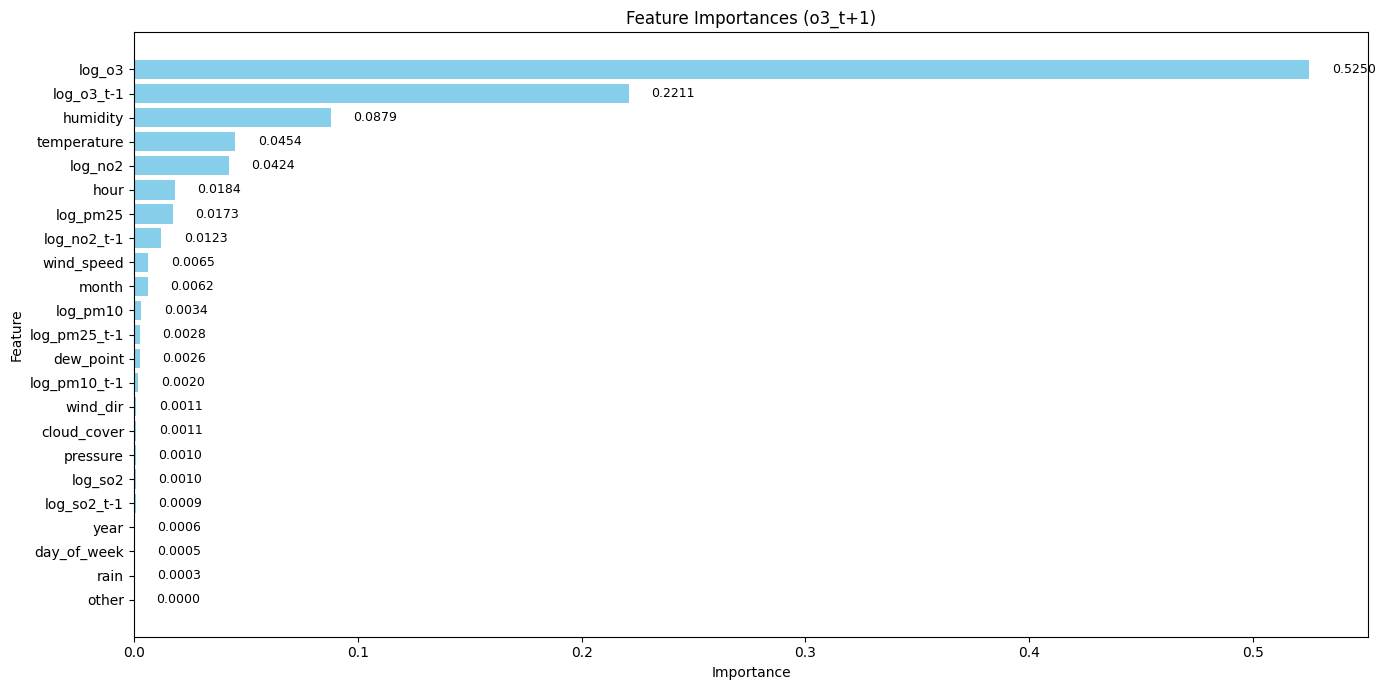

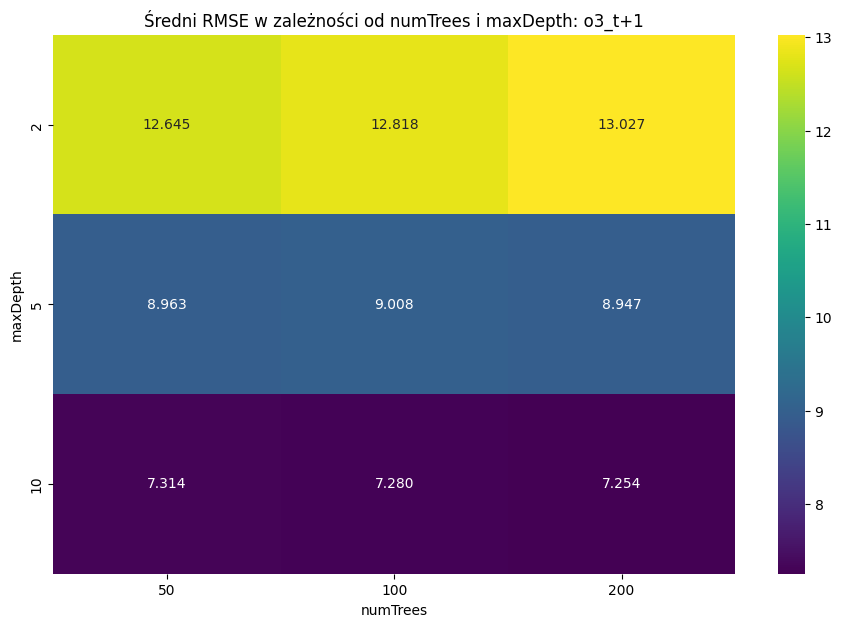

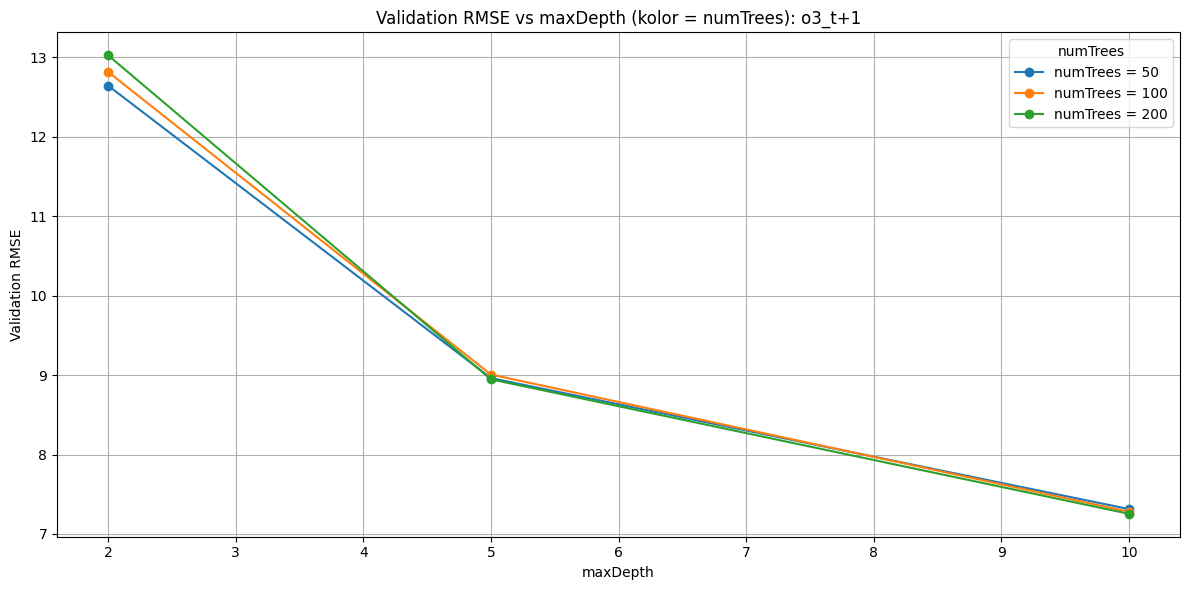

In [19]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "o3_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_o3_log_only_f"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)


Testuję parametry: numTrees=50, maxDepth=2
 Fold 1: RMSE=1.2698, R2=0.5470
 Fold 2: RMSE=1.2734, R2=0.5977
 Fold 3: RMSE=0.8390, R2=0.6392
 Średni RMSE dla parametrów numTrees=50, maxDepth=2: 1.1274
 Średni R2 dla parametrów numTrees=50, maxDepth=2: 0.5947

Testuję parametry: numTrees=50, maxDepth=5
 Fold 1: RMSE=1.0748, R2=0.6754
 Fold 2: RMSE=1.0410, R2=0.7312
 Fold 3: RMSE=0.7230, R2=0.7321
 Średni RMSE dla parametrów numTrees=50, maxDepth=5: 0.9463
 Średni R2 dla parametrów numTrees=50, maxDepth=5: 0.7129

Testuję parametry: numTrees=50, maxDepth=10


25/05/31 09:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1090.6 KiB
25/05/31 09:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1951.2 KiB
25/05/31 09:46:35 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/05/31 09:46:37 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
25/05/31 09:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1234.3 KiB
                                                                                

 Fold 1: RMSE=1.0684, R2=0.6793


25/05/31 09:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
25/05/31 09:46:45 WARN DAGScheduler: Broadcasting large task binary with size 2017.6 KiB
25/05/31 09:46:46 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/31 09:46:48 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/05/31 09:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1503.7 KiB
                                                                                

 Fold 2: RMSE=1.0137, R2=0.7451


25/05/31 09:46:56 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
25/05/31 09:46:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:46:59 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1031.6 KiB
25/05/31 09:47:02 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
25/05/31 09:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1768.7 KiB
                                                                                

 Fold 3: RMSE=0.7054, R2=0.7450
 Średni RMSE dla parametrów numTrees=50, maxDepth=10: 0.9292
 Średni R2 dla parametrów numTrees=50, maxDepth=10: 0.7231

Testuję parametry: numTrees=100, maxDepth=2
 Fold 1: RMSE=1.2830, R2=0.5375


 Fold 2: RMSE=1.3009, R2=0.5802


 Fold 3: RMSE=0.8598, R2=0.6211
 Średni RMSE dla parametrów numTrees=100, maxDepth=2: 1.1479
 Średni R2 dla parametrów numTrees=100, maxDepth=2: 0.5796

Testuję parametry: numTrees=100, maxDepth=5
 Fold 1: RMSE=1.0907, R2=0.6657


 Fold 2: RMSE=1.0496, R2=0.7267


 Fold 3: RMSE=0.7226, R2=0.7324
 Średni RMSE dla parametrów numTrees=100, maxDepth=5: 0.9543
 Średni R2 dla parametrów numTrees=100, maxDepth=5: 0.7083

Testuję parametry: numTrees=100, maxDepth=10


25/05/31 09:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1108.6 KiB
25/05/31 09:47:41 WARN DAGScheduler: Broadcasting large task binary with size 2034.6 KiB
25/05/31 09:47:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 09:47:44 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
25/05/31 09:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1591.3 KiB
25/05/31 09:47:47 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
25/05/31 09:47:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
                                                                                

 Fold 1: RMSE=1.0635, R2=0.6822


25/05/31 09:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1114.4 KiB
25/05/31 09:47:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:48:01 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.7 KiB
25/05/31 09:48:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
25/05/31 09:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1841.2 KiB
25/05/31 09:48:08 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
25/05/31 09:48:12 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
                                                                                

 Fold 2: RMSE=1.0116, R2=0.7461


25/05/31 09:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1120.6 KiB
25/05/31 09:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:48:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1153.3 KiB
25/05/31 09:48:31 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 09:48:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:48:37 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
25/05/31 09:48:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
                                                                                

 Fold 3: RMSE=0.7034, R2=0.7464
 Średni RMSE dla parametrów numTrees=100, maxDepth=10: 0.9262
 Średni R2 dla parametrów numTrees=100, maxDepth=10: 0.7249

Testuję parametry: numTrees=200, maxDepth=2


 Fold 1: RMSE=1.2841, R2=0.5367


 Fold 2: RMSE=1.3036, R2=0.5784


 Fold 3: RMSE=0.8709, R2=0.6112
 Średni RMSE dla parametrów numTrees=200, maxDepth=2: 1.1529
 Średni R2 dla parametrów numTrees=200, maxDepth=2: 0.5755

Testuję parametry: numTrees=200, maxDepth=5


25/05/31 09:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1100.2 KiB
                                                                                

 Fold 1: RMSE=1.0928, R2=0.6645


25/05/31 09:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1100.5 KiB
                                                                                

 Fold 2: RMSE=1.0518, R2=0.7255


25/05/31 09:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
                                                                                

 Fold 3: RMSE=0.7260, R2=0.7298
 Średni RMSE dla parametrów numTrees=200, maxDepth=5: 0.9569
 Średni R2 dla parametrów numTrees=200, maxDepth=5: 0.7066

Testuję parametry: numTrees=200, maxDepth=10


25/05/31 09:49:36 WARN DAGScheduler: Broadcasting large task binary with size 1100.2 KiB
25/05/31 09:49:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:49:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/31 09:49:41 WARN DAGScheduler: Broadcasting large task binary with size 1108.0 KiB
25/05/31 09:49:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
25/05/31 09:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1933.7 KiB
25/05/31 09:49:47 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
25/05/31 09:49:50 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/05/31 09:50:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
25/05/31 09:50:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
                                                                                

 Fold 1: RMSE=1.0712, R2=0.6776


25/05/31 09:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1100.5 KiB
25/05/31 09:50:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/05/31 09:50:32 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/05/31 09:50:35 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
25/05/31 09:50:37 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
25/05/31 09:50:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:50:44 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
25/05/31 09:50:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/31 09:50:56 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
25/05/31 09:51:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/05/31 09:51:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
25/05/31 09:51:09 WARN DAGScheduler: Broadcast

 Fold 2: RMSE=1.0106, R2=0.7466


25/05/31 09:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1101.8 KiB
25/05/31 09:51:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:51:29 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1209.3 KiB
25/05/31 09:51:35 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/05/31 09:51:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/31 09:51:44 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
25/05/31 09:51:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/05/31 09:52:00 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
25/05/31 09:52:09 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/05/31 09:52:15 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
25/05/31 09:52:17 WARN DAGScheduler: Broadcast

 Fold 3: RMSE=0.7009, R2=0.7482
 Średni RMSE dla parametrów numTrees=200, maxDepth=10: 0.9276
 Średni R2 dla parametrów numTrees=200, maxDepth=10: 0.7242
Najlepsze parametry: {'numTrees': 100, 'maxDepth': 10} z RMSE: 0.9261610163437157


25/05/31 09:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1107.8 KiB
25/05/31 09:52:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:52:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/31 09:52:38 WARN DAGScheduler: Broadcasting large task binary with size 1175.1 KiB
25/05/31 09:52:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/05/31 09:52:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/05/31 09:52:47 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
25/05/31 09:52:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/31 09:53:00 WARN TaskSetManager: Stage 26775 contains a task of very large size (6233 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

Model zapisany na HDFS pod: hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2_log_only_f
Test set RMSE: 0.5817
Test set R2: 0.7685


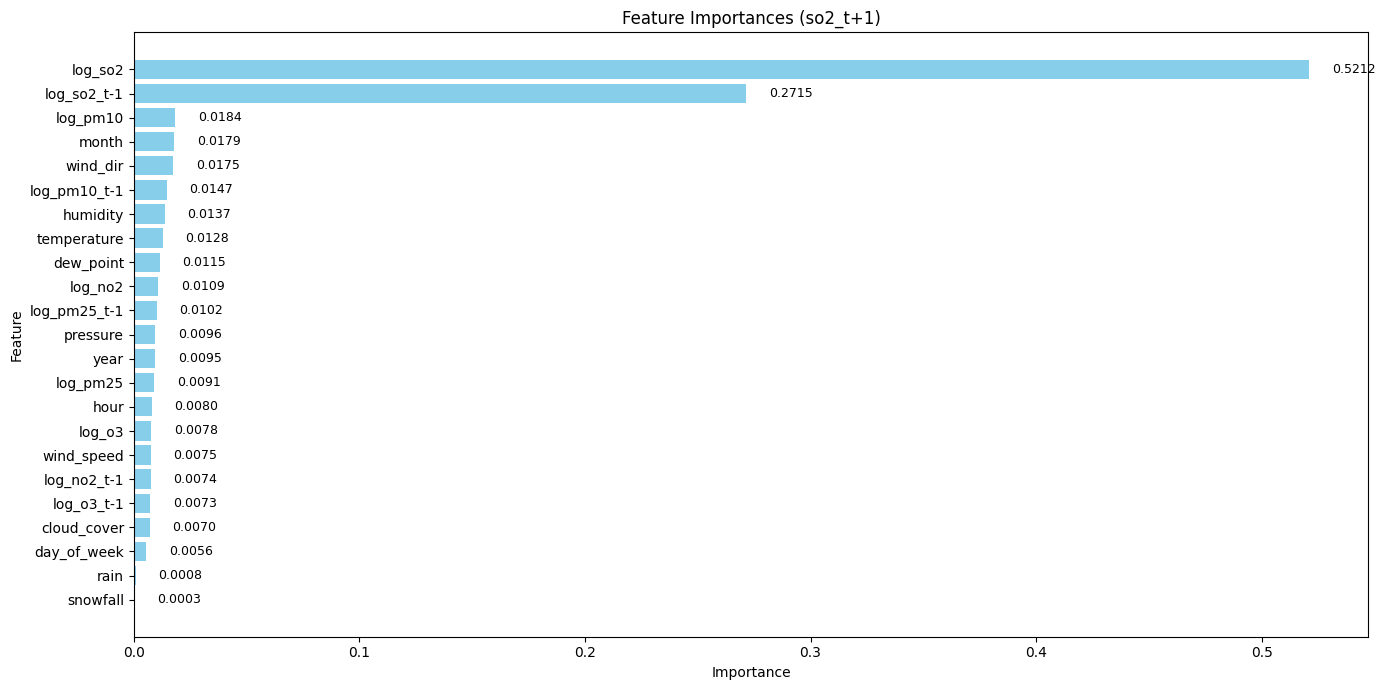

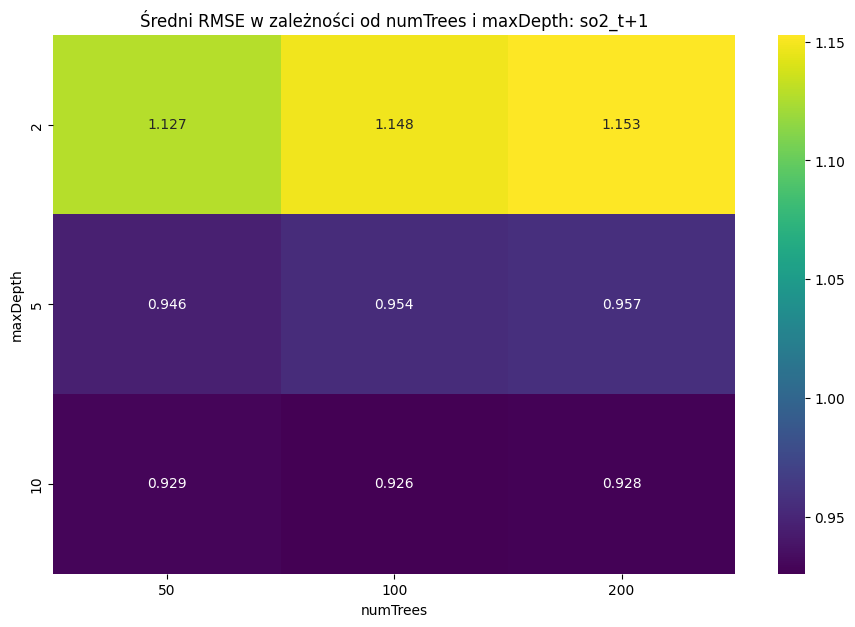

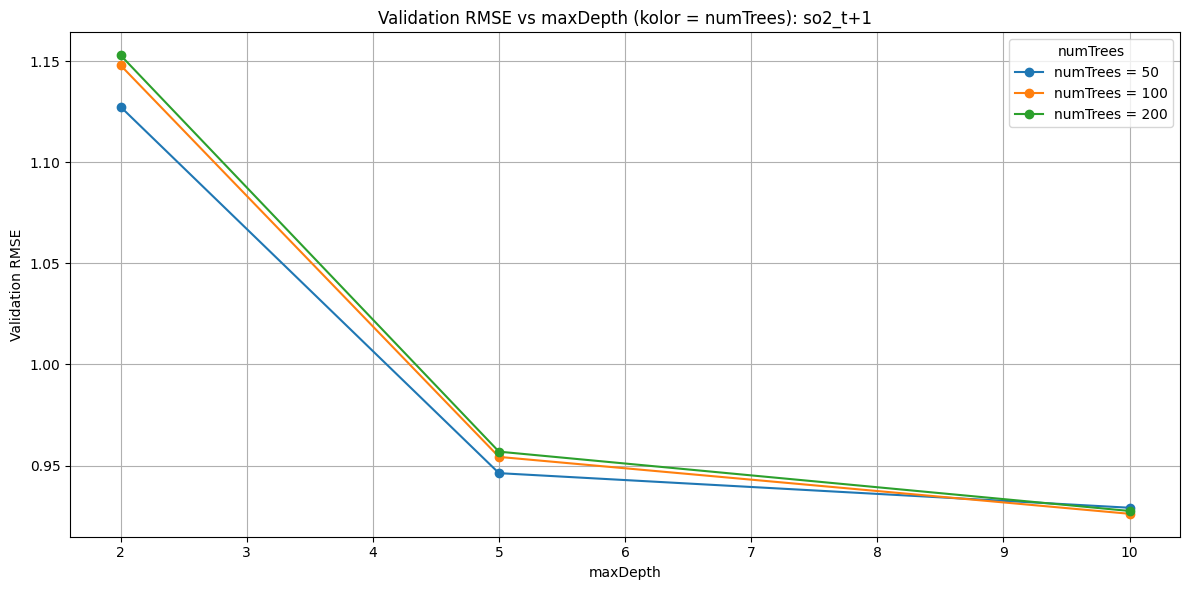

In [20]:
pollutants = ["pm10", "pm25", "no2", "so2", "o3"]

feature_cols = [
    "temperature", "humidity", "dew_point", "rain", "snowfall", "pressure", "cloud_cover", "wind_speed", "wind_dir",
    "hour", "day_of_week", "month", "year",
    "log_pm10", "log_pm25", "log_no2", "log_o3", "log_so2",
    "log_pm10_t-1", "log_pm25_t-1", "log_no2_t-1", "log_o3_t-1", "log_so2_t-1"
]

target_col = "so2_t+1"

param_grid = {
    "numTrees": [50, 100, 200],
    "maxDepth": [2, 5, 10]
}

model_save_path = "hdfs://namenode:9000/user/hadoop/modele/offline_cv/offline_rf_so2_log_only_f"

best_params, offline_model_pm10 = timeseries_cv_rf(
    df_to_cv=df,
    datetime_col="datetime_utc",
    feature_cols=feature_cols,
    target_col=target_col,
    param_grid=param_grid,
    folds=3,
    model_save_path=model_save_path
)